### Group 28 members:
- Jingze Tian (jingze4)
- Letian Ren (letian2)
- Essam Gouda (egouda)

# Task 1: Regression
- Linear Regression for no_of_Mosquito = function(weather_features)
- Linear Regression for no_of_Mosquito_female = function(weather_features)
- Polynomial Regression for no_of_Mosquito_female = function(weather_features)

#### Variations for each model:
- Different cost functions were tested
- Model without normalization and standardization, model with normalization only, model with standardization only, model with both normalization and standardization.
- Feature selection
- model statistics compared at the end

## Imports

In [1]:
import pandas as pd
import numpy as np
import time


import matplotlib.pyplot as plt
plt.rc("font", size=14)
import seaborn as sns
sns.set(style="white") #white bg for sns plots
sns.set(style="whitegrid", color_codes=True)

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

from scipy.stats import ks_2samp

import warnings; warnings.simplefilter('ignore')

## Read csv files (datasets)

In [2]:
weather_data = pd.read_csv('./data/weather_data.csv')
mos_data = pd.read_csv('./data/mosquito_data_new.csv')

In [3]:
mos_data.head()

,Trap Date,Genus,Specific Epithet,Gender,IDd,Count,Trap Region,Include,Comparison Group,Latitude,Longitude,Location
0,09/15/2015 12:00:00 AM,Aedes,vexans,Female,NaN,3,Rural-West,NaN,Outer,53.562973,-113.787353,POINT (-113.787353 53.5629733)
1,05/12/1998 12:00:00 AM,Male,UnID,Male,UnID,1,Rural-North West,NaN,Peripheral,53.617221,-113.716182,POINT (-113.716182 53.617221)
2,08/28/2001 12:00:00 AM,Culex,tarsalis,Female,NaN,1,Rural-North West,NaN,Peripheral,53.617221,-113.716182,POINT (-113.716182 53.617221)
3,08/17/2004 12:00:00 AM,Culex,territans,Female,NaN,1,Rural-North West,NaN,Peripheral,53.617221,-113.716182,POINT (-113.716182 53.617221)
4,05/15/2018 12:00:00 AM,Culiseta,impatiens,Female,NaN,2,Rural-West,NaN,Outer,53.559020,-114.001190,POINT (-114.00119 53.559020000000004)


In [4]:
weather_data.head()

,date_time_local,unixtime,pressure_station,pressure_sea,wind_dir,wind_dir_10s,wind_speed,wind_gust,relative_humidity,dew_point,temperature,windchill,humidex,visibility,health_index,cloud_cover_4,cloud_cover_8,cloud_cover_10,solar_radiation
0,2018-12-18 16:00:00 MST,1545174000,91.73,99.7,SW,23.0,5.0,NaN,64.0,-7.3,-1.3,-3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-12-18 15:00:00 MST,1545170400,91.67,99.7,S,18.0,5.0,NaN,65.0,-6.3,-0.5,-2.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN
2,2018-12-18 14:00:00 MST,1545166800,91.67,99.6,S,17.0,5.0,NaN,51.0,-6.5,2.7,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN
3,2018-12-18 13:00:00 MST,1545163200,91.66,99.6,SE,13.0,2.0,NaN,50.0,-6.4,2.9,NaN,NaN,NaN,3.9,NaN,NaN,NaN,NaN
4,2018-12-18 12:00:00 MST,1545159600,91.75,99.7,NaN,NaN,0.0,NaN,59.0,-6.6,0.5,NaN,NaN,NaN,4.1,NaN,NaN,NaN,NaN


### Get total count for each day

In [5]:
mos_count = mos_data.groupby(["Trap Date"]).agg({
    "Count":"sum",
})
mos_count[mos_count['Count'] == mos_count['Count'].max()]

mos_count.head() ####number of mos

,Count
Trap Date,
04/08/1992 12:00:00 AM,604
05/05/1992 12:00:00 AM,120
05/05/2020 12:00:00 AM,8
05/07/2013 12:00:00 AM,4
05/07/2019 12:00:00 AM,1


In [6]:
len(mos_count.index)

584

It can be seen that IDd and Include columns contains many NaN values so they will be dropped

In [7]:
mos_data.isnull().sum()

Trap Date               0
Genus                   4
Specific Epithet        4
Gender                  4
IDd                 20205
Count                   0
Trap Region             4
Include             26434
Comparison Group        4
Latitude                4
Longitude               4
Location                4
dtype: int64

In [8]:
mos_data.drop(columns=['IDd', 'Include'], inplace=True)

In [9]:
mos_data.isnull().sum()

Trap Date           0
Genus               4
Specific Epithet    4
Gender              4
Count               0
Trap Region         4
Comparison Group    4
Latitude            4
Longitude           4
Location            4
dtype: int64

### Select date for weather features and mosquito data

Drop MST columns
Drop columns with too many NaNs
Drop unixtime columns as they are redundent
Drop wind_dir column as wind_dir_10s gives us the angle of the wind so its redundent

### Date selection

In [10]:
t_list = []
for i in mos_data['Trap Date']:
    i = str(i)
    t1 = time.strptime(i,"%m/%d/%Y %H:%M:%S AM")
    t2 = time.strftime("%Y-%m-%d", t1)
    t_list.append(t2)

mos_data['Trap Date'] = t_list


mos_data['Trap Date'] = pd.to_datetime(mos_data['Trap Date'])

############data select#############
start_remove = min(weather_data['date_time_local'])
end_remove = max(weather_data['date_time_local'])
mos_data_1 = mos_data.loc[(mos_data["Trap Date"] >= start_remove) & (mos_data["Trap Date"] <= end_remove) ]
mos_date_start = str(mos_data_1['Trap Date'].dt.date.min())
mos_date_end = str(mos_data_1['Trap Date'].dt.date.max())
mos_date_range = mos_date_start +' to ' + mos_date_end
print("Range of dates in mosquito dataset is {}".format(mos_date_range))

mos_data['Trap Date'] = pd.to_datetime(mos_data['Trap Date'])
mos_range = (mos_data['Trap Date'] >= mos_date_start) & (mos_data['Trap Date'] <= mos_date_end)
mos_data = mos_data.loc[mos_range]
mos_data = mos_data.sort_values(by='Trap Date')


mos_count = mos_data.groupby(["Trap Date"]).agg({
    "Count":"sum",
})
mos_count[mos_count['Count'] == mos_count['Count'].max()]

Range of dates in mosquito dataset is 2017-05-09 to 2018-09-25


,Count
Trap Date,
2018-06-12,9938


In [11]:
start_date1 = '2017-05-03' #one week before 2017-05-09
end_date1 = '2017-09-26'
start_date2 = '2018-05-09' #one week before 2018-05-15
end_date2 = '2018-09-25'

##############Drop MST###################
weather_data.drop(columns=["visibility", "cloud_cover_4", "cloud_cover_8", "cloud_cover_10", "solar_radiation", "wind_gust", "windchill", "humidex"], inplace=True)
weather_data = weather_data.loc[weather_data['date_time_local'].str.contains('MDT')]


t_list = []
for i in weather_data['date_time_local']:
    i = str(i)
    t1 = time.strptime(i,"%Y-%m-%d %H:%M:%S MDT")
    t2 = time.strftime("%Y-%m-%d", t1)
    t_list.append(t2)

weather_data['date_time_local'] = t_list


weather_data['date_time_local'] = pd.to_datetime(weather_data['date_time_local'])
weather_range1 = (weather_data['date_time_local'] >= start_date1) & (weather_data['date_time_local'] <= end_date1)
weather_data1 = weather_data.loc[weather_range1]
weather_data1 = weather_data1.sort_values(by='date_time_local')


weather_range2 = (weather_data['date_time_local'] >= start_date2) & (weather_data['date_time_local'] <= end_date2)
weather_data2 = weather_data.loc[weather_range2]
weather_data2 = weather_data2.sort_values(by='date_time_local')
weather_data = weather_data1.append(weather_data2)

#### Fill NaN for weather_data

In [12]:
weather_data.isnull().sum()

date_time_local       0
unixtime              0
pressure_station      1
pressure_sea          1
wind_dir             50
wind_dir_10s         11
wind_speed            1
relative_humidity     1
dew_point             1
temperature           1
health_index         50
dtype: int64

In [13]:
len(weather_data.index)

6888

#### To fill the NaNs we will group the weather data by day and there is 3 ways to do that for each column:
- By mean
- By mode
- By median

for each day, to do so we will need to visualize the distribution for each column and ensure that it stays similar after grouping to not add any bias to the data.

### Pressure station

In [14]:
weather_data['pressure_station'].describe()

count    6887.000000
mean       93.554866
std         0.606001
min        90.790000
25%        93.150000
50%        93.580000
75%        93.980000
max        95.210000
Name: pressure_station, dtype: float64

#### mean

In [15]:
pressure_station_mean = weather_data.groupby('date_time_local').agg({
  'pressure_station': lambda x: round(x.mean(), 2)  
})

pressure_station_mean.describe()

,pressure_station
count,287.000000
mean,93.554948
std,0.580993
min,91.360000
25%,93.190000
50%,93.570000
75%,94.000000
max,94.980000


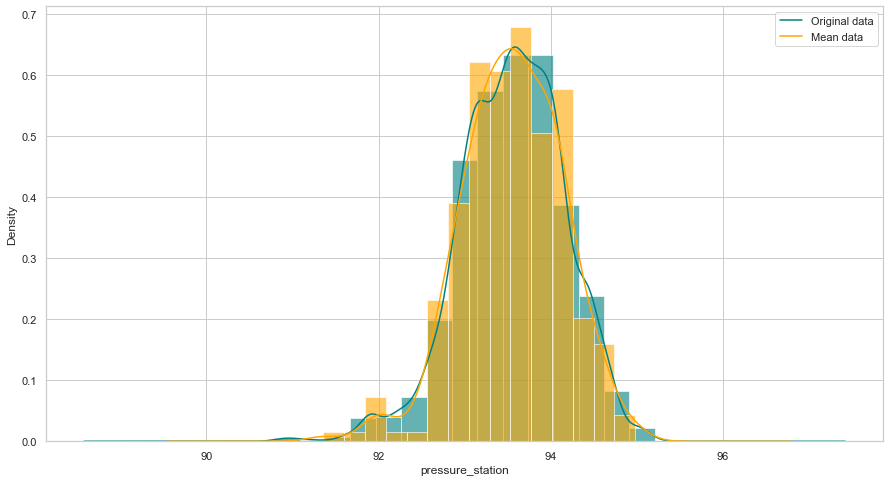

In [16]:
key_to_test = 'pressure_station'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = pressure_station_mean[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
pressure_station_mean[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Mean data'])
ax.set(xlabel=key_to_test)

plt.show()

In [17]:
ks_2samp(weather_data['pressure_station'], pressure_station_mean['pressure_station'])

KstestResult(statistic=0.02569686411149826, pvalue=0.9914493962614249)

#### mode

In [18]:
pressure_station_mode = weather_data.groupby('date_time_local').agg({
  'pressure_station': lambda x: x.value_counts().index[0]  
})

pressure_station_mode.describe()

,pressure_station
count,287.000000
mean,93.551463
std,0.622930
min,90.920000
25%,93.140000
50%,93.600000
75%,93.990000
max,95.060000


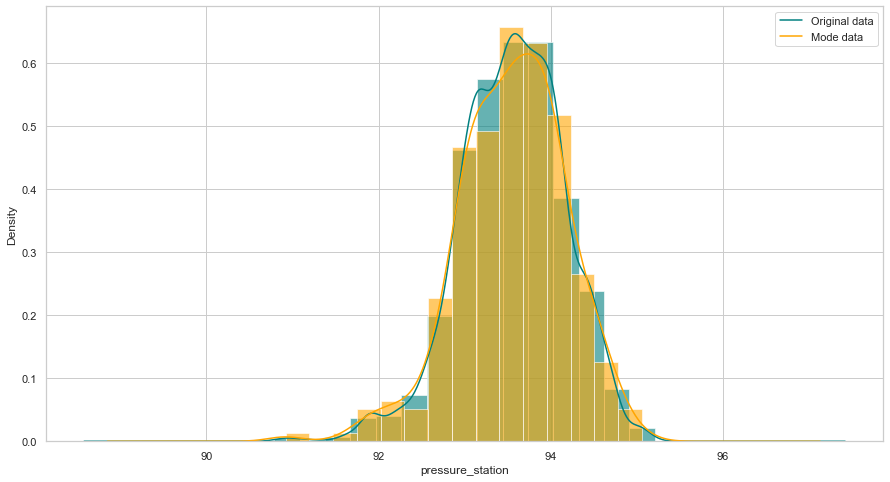

In [19]:
key_to_test = 'pressure_station'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = pressure_station_mode[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
pressure_station_mode[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Mode data'])
ax.set(xlabel=key_to_test)

plt.show()

In [20]:
ks_2samp(weather_data['pressure_station'], pressure_station_mode['pressure_station'])

KstestResult(statistic=0.028310104529616725, pvalue=0.9759773776787382)

#### median

In [21]:
pressure_station_median = weather_data.groupby('date_time_local').agg({
  'pressure_station': lambda x: x.median() 
})

pressure_station_median.describe()

,pressure_station
count,287.000000
mean,93.571672
std,0.598979
min,91.110000
25%,93.190000
50%,93.575000
75%,93.997500
max,94.985000


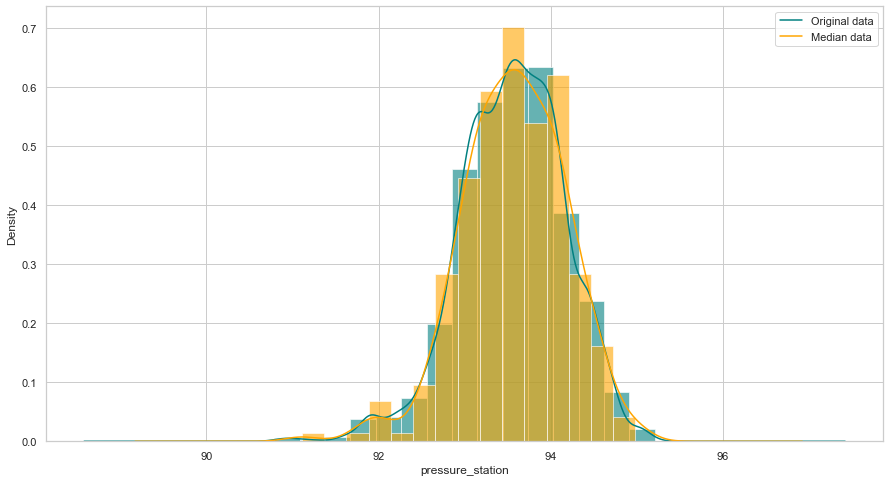

In [22]:
key_to_test = 'pressure_station'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = pressure_station_median[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
pressure_station_median[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Median data'])
ax.set(xlabel=key_to_test)

plt.show()

In [23]:
ks_2samp(weather_data['pressure_station'], pressure_station_median['pressure_station'])

KstestResult(statistic=0.03193960511033682, pvalue=0.9334573793187272)

It can be seen that for pressure station mode has the highest p-value so it will be chosen for grouping

### Pressure sea

In [24]:
weather_data['pressure_sea'].describe()

count    6887.000000
mean      101.402508
std         0.672463
min        98.400000
25%       100.900000
50%       101.400000
75%       101.900000
max       103.200000
Name: pressure_sea, dtype: float64

#### mean

In [25]:
pressure_sea_mean = weather_data.groupby('date_time_local').agg({
  'pressure_sea': lambda x: round(x.mean(), 2)  
})

pressure_sea_mean.describe()

,pressure_sea
count,287.000000
mean,101.402334
std,0.642834
min,99.020000
25%,100.985000
50%,101.380000
75%,101.885000
max,102.980000


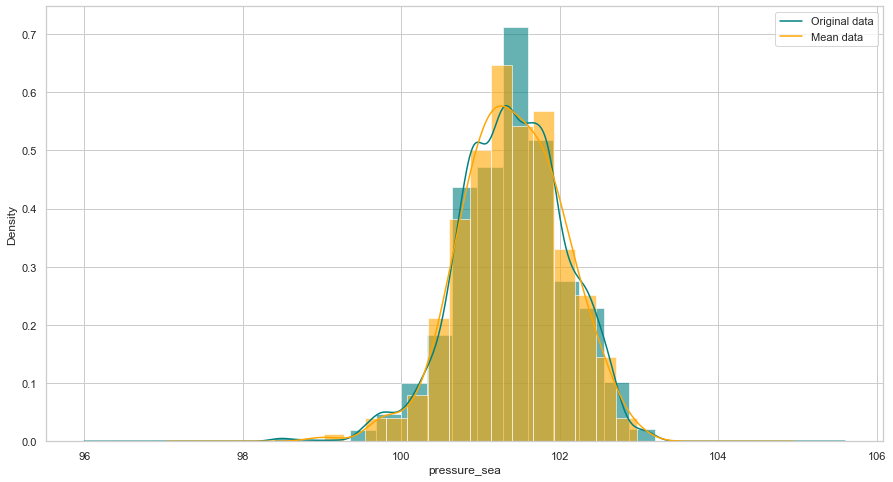

In [26]:
key_to_test = 'pressure_sea'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = pressure_sea_mean[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
pressure_sea_mean[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Mean data'])
ax.set(xlabel=key_to_test)

plt.show()

In [27]:
ks_2samp(weather_data['pressure_sea'], pressure_sea_mean['pressure_sea'])

KstestResult(statistic=0.04006968641114982, pvalue=0.753920014886809)

#### mode

In [28]:
pressure_sea_mode = weather_data.groupby('date_time_local').agg({
  'pressure_sea': lambda x: x.value_counts().index[0]  
})

pressure_sea_mode.describe()

,pressure_sea
count,287.000000
mean,101.429965
std,0.695093
min,98.500000
25%,100.950000
50%,101.400000
75%,101.900000
max,103.200000


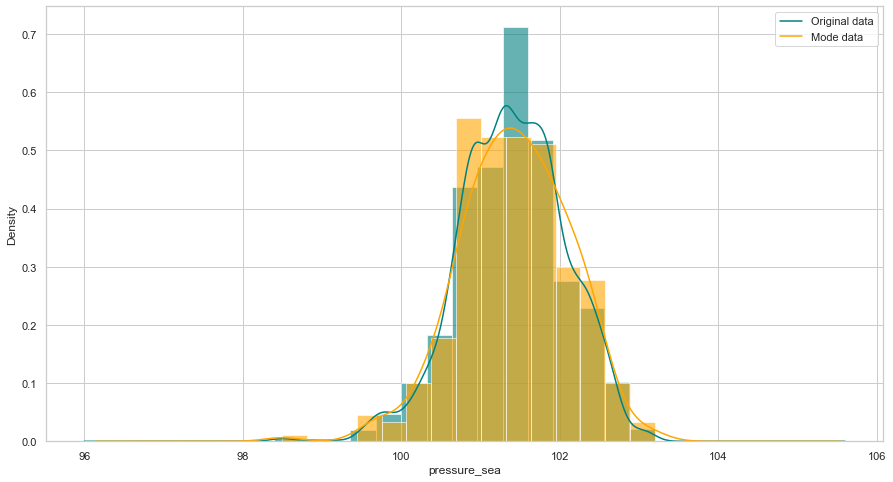

In [29]:
key_to_test = 'pressure_sea'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = pressure_sea_mode[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
pressure_sea_mode[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Mode data'])
ax.set(xlabel=key_to_test)

plt.show()

In [30]:
ks_2samp(weather_data['pressure_sea'], pressure_sea_mode['pressure_sea'])

KstestResult(statistic=0.03876306620209059, pvalue=0.7884035891792024)

#### median

In [31]:
pressure_sea_median = weather_data.groupby('date_time_local').agg({
  'pressure_sea': lambda x: x.median() 
})

pressure_sea_median.describe()

,pressure_sea
count,287.000000
mean,101.419512
std,0.658571
min,98.750000
25%,101.000000
50%,101.400000
75%,101.900000
max,103.000000


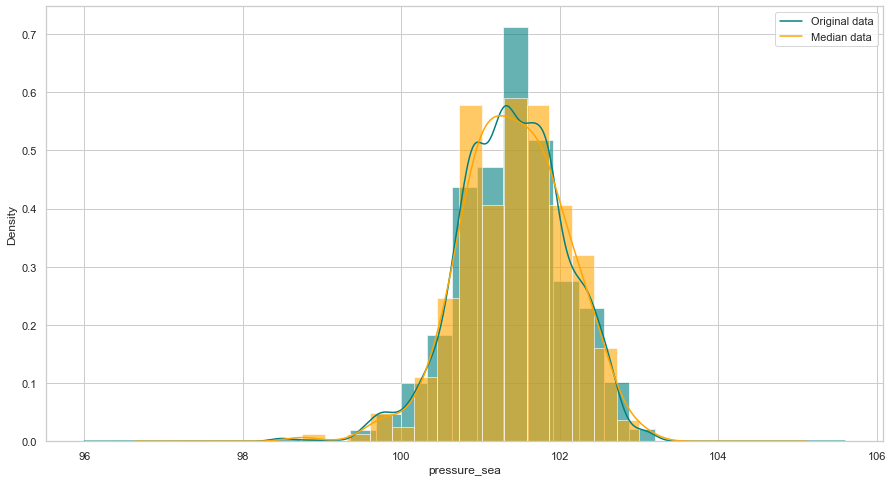

In [32]:
key_to_test = 'pressure_sea'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = pressure_sea_median[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
pressure_sea_median[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Median data'])
ax.set(xlabel=key_to_test)

plt.show()

In [33]:
ks_2samp(weather_data['pressure_sea'], pressure_sea_median['pressure_sea'])

KstestResult(statistic=0.034552845528455285, pvalue=0.8867104215811252)

It can be seen that for pressure sea median has the highest p-value so it will be chosen for grouping

## Wind_dir_10s
This column represents the wind direction in angles so taking a mean or median doesn't make much sense and mode is expected to be the best method.

In [34]:
weather_data['wind_dir_10s'].describe()

count    6877.000000
mean       21.359604
std         9.904530
min         1.000000
25%        14.000000
50%        23.000000
75%        30.000000
max        36.000000
Name: wind_dir_10s, dtype: float64

#### mean

In [35]:
wind_dir_10s_mean = weather_data.groupby('date_time_local').agg({
  'wind_dir_10s': lambda x: round(x.mean(), 1)  
})

wind_dir_10s_mean.describe()

,wind_dir_10s
count,287.000000
mean,21.362718
std,6.256703
min,5.600000
25%,16.800000
50%,21.900000
75%,26.700000
max,34.400000


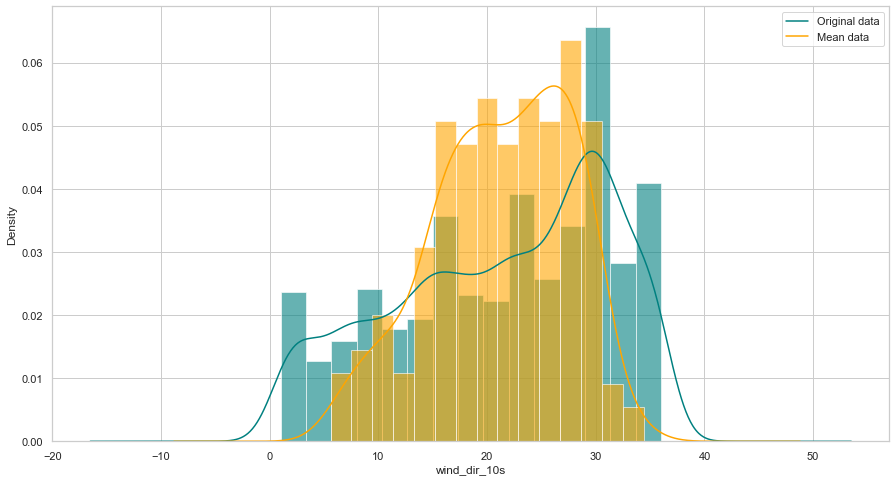

In [36]:
key_to_test = 'wind_dir_10s'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = wind_dir_10s_mean[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
wind_dir_10s_mean[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Mean data'])
ax.set(xlabel=key_to_test)

plt.show()

In [37]:
ks_2samp(weather_data['wind_dir_10s'], wind_dir_10s_mean['wind_dir_10s'])

KstestResult(statistic=0.2260452961672474, pvalue=7.666089985036706e-13)

#### mode

In [38]:
wind_dir_10s_mode = weather_data.groupby('date_time_local').agg({
  'wind_dir_10s': lambda x: x.value_counts().index[0]   
})

wind_dir_10s_mode.describe()

,wind_dir_10s
count,287.000000
mean,22.114983
std,9.604633
min,1.000000
25%,15.000000
50%,24.000000
75%,30.000000
max,36.000000


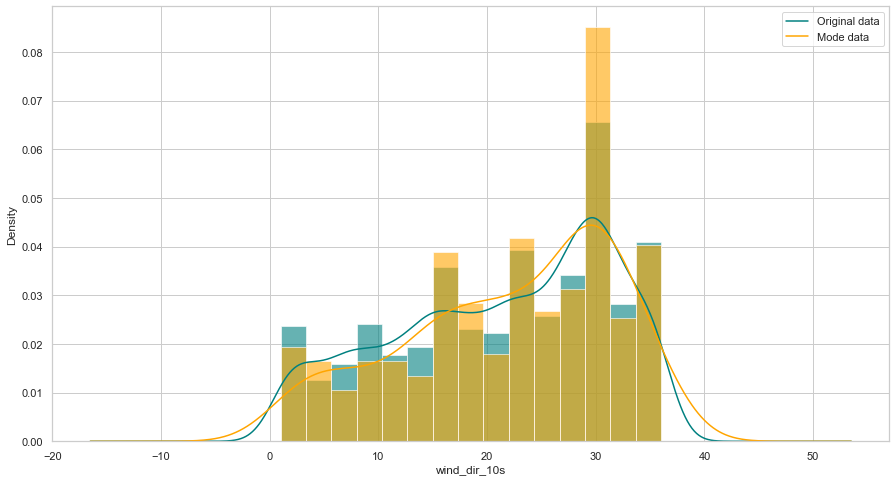

In [39]:
key_to_test = 'wind_dir_10s'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = wind_dir_10s_mode[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
wind_dir_10s_mode[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Mode data'])
ax.set(xlabel=key_to_test)

plt.show()

In [40]:
ks_2samp(weather_data['wind_dir_10s'], wind_dir_10s_mode['wind_dir_10s'])

KstestResult(statistic=0.04863530778164925, pvalue=0.5178542828300277)

#### median

In [41]:
wind_dir_10s_median = weather_data.groupby('date_time_local').agg({
  'wind_dir_10s': lambda x: x.median()  
})

wind_dir_10s_median.describe()

,wind_dir_10s
count,287.000000
mean,21.858885
std,7.861683
min,2.500000
25%,16.250000
50%,22.000000
75%,28.500000
max,35.000000


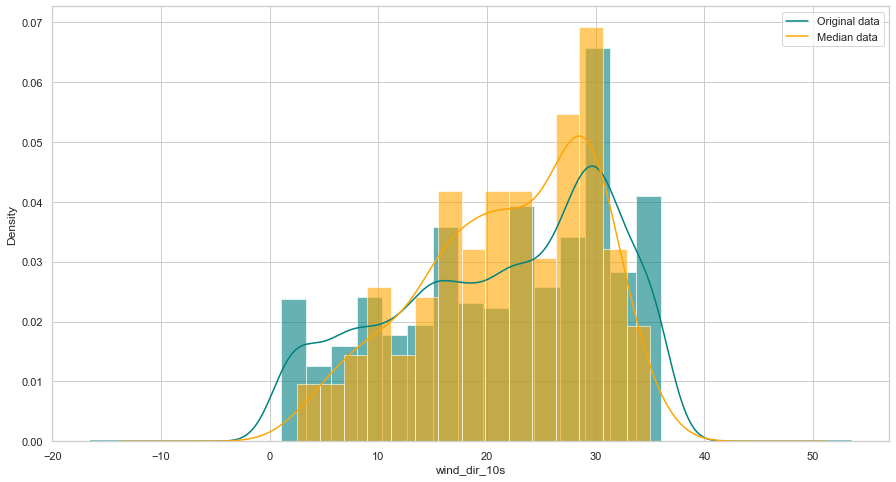

In [42]:
key_to_test = 'wind_dir_10s'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = wind_dir_10s_median[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
wind_dir_10s_median[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Median data'])
ax.set(xlabel=key_to_test)

plt.show()

In [43]:
ks_2samp(weather_data['wind_dir_10s'], wind_dir_10s_median['wind_dir_10s'])

KstestResult(statistic=0.10104529616724739, pvalue=0.006718571849352317)

As expected mode will be the chosen value for wind_dir_10s column as it has the highest p-value, it can be seen that mean doesn't even follow the same distribution and the median barely does follow it.

## Wind_speed

In [44]:
weather_data['wind_speed'].describe()

count    6887.000000
mean       11.795992
std         6.751474
min         0.000000
25%         7.000000
50%        11.000000
75%        16.000000
max        48.000000
Name: wind_speed, dtype: float64

#### mean

In [45]:
wind_speed_mean = weather_data.groupby('date_time_local').agg({
  'wind_speed': lambda x: round(x.mean(),1)  
})

wind_speed_mean.describe()

,wind_speed
count,287.000000
mean,11.797213
std,4.450229
min,3.300000
25%,8.600000
50%,11.400000
75%,14.200000
max,34.800000


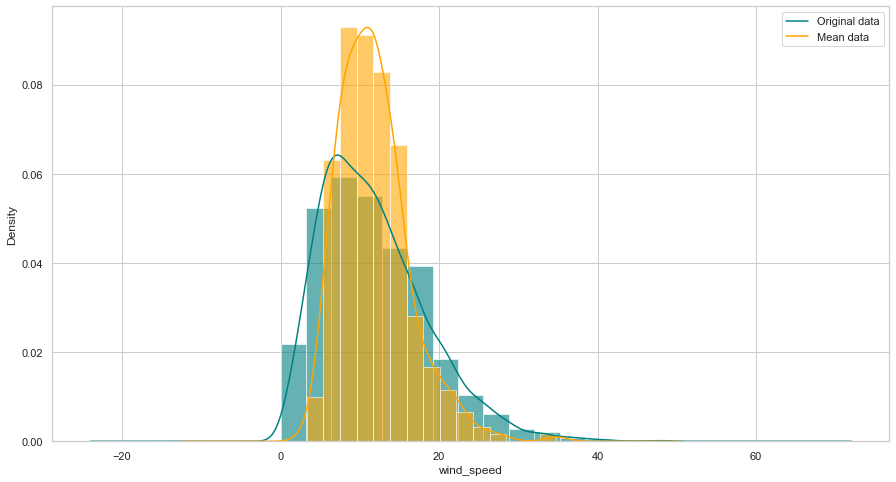

In [46]:
key_to_test = 'wind_speed'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = wind_speed_mean[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
wind_speed_mean[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Mean data'])
ax.set(xlabel=key_to_test)

plt.show()

In [47]:
ks_2samp(weather_data['wind_speed'], wind_speed_mean['wind_speed'])

KstestResult(statistic=0.18495934959349594, pvalue=1.0240286396623333e-08)

#### mode

In [48]:
wind_speed_mode = weather_data.groupby('date_time_local').agg({
  'wind_speed': lambda x: x.value_counts().index[0]  
})

wind_speed_mode.describe()

,wind_speed
count,287.000000
mean,11.184669
std,6.407822
min,1.000000
25%,6.000000
50%,10.000000
75%,14.000000
max,48.000000


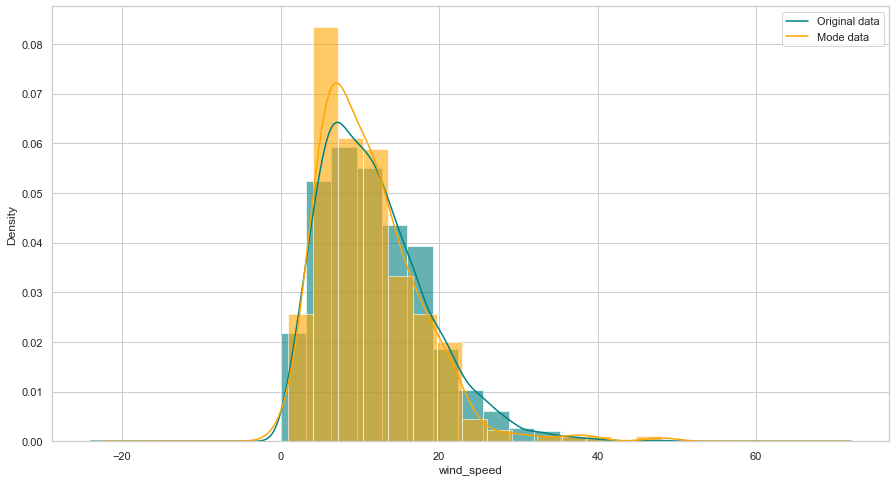

In [49]:
key_to_test = 'wind_speed'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = wind_speed_mode[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
wind_speed_mode[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Mode data'])
ax.set(xlabel=key_to_test)

plt.show()

In [50]:
ks_2samp(weather_data['wind_speed'], wind_speed_mode['wind_speed'])

KstestResult(statistic=0.06475029036004645, pvalue=0.19053742644330318)

#### median

In [51]:
wind_speed_median = weather_data.groupby('date_time_local').agg({
  'wind_speed': lambda x: x.median()  
})

wind_speed_median.describe()

,wind_speed
count,287.000000
mean,11.529617
std,4.823818
min,3.000000
25%,8.000000
50%,11.000000
75%,14.000000
max,36.500000


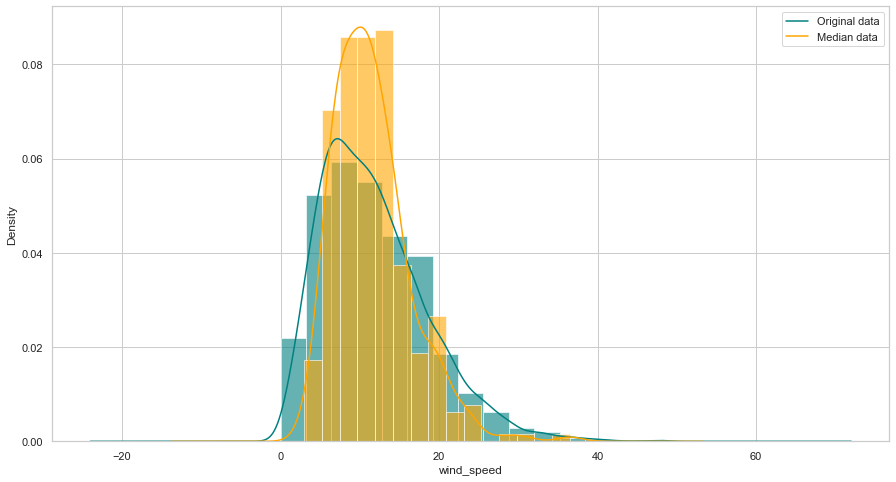

In [52]:
key_to_test = 'wind_speed'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = wind_speed_median[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
wind_speed_median[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Median data'])
ax.set(xlabel=key_to_test)

plt.show()

In [53]:
ks_2samp(weather_data['wind_speed'], wind_speed_median['wind_speed'])

KstestResult(statistic=0.13617886178861788, pvalue=6.493915887662016e-05)

Mode will be used for wind_speed

## Relative_humidty

In [54]:
weather_data['relative_humidity'].describe()

count    6887.000000
mean       59.706984
std        21.765993
min        14.000000
25%        41.000000
50%        60.000000
75%        79.000000
max        99.000000
Name: relative_humidity, dtype: float64

#### mean

In [55]:
relative_humidity_mean = weather_data.groupby('date_time_local').agg({
  'relative_humidity': lambda x: round(x.mean(),1)
})

relative_humidity_mean.describe()

,relative_humidity
count,287.000000
mean,59.707317
std,14.947495
min,27.000000
25%,48.150000
50%,59.200000
75%,69.700000
max,95.600000


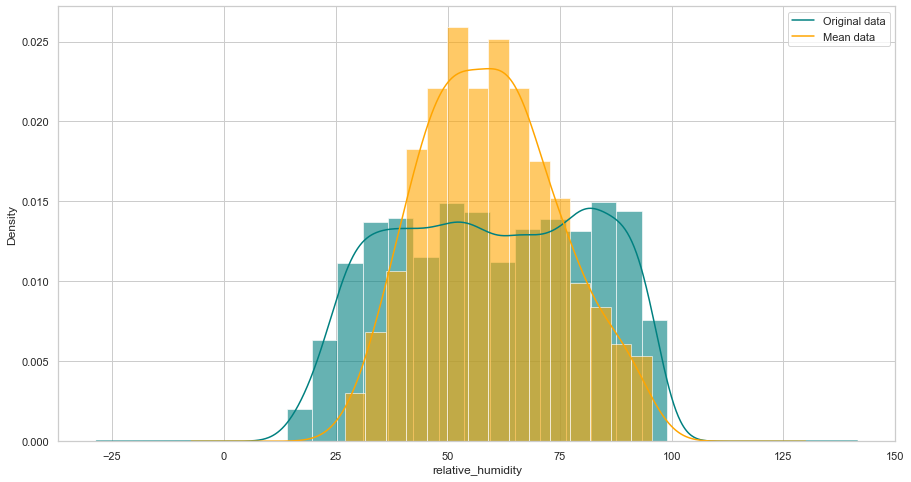

In [56]:
key_to_test = 'relative_humidity'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = relative_humidity_mean[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
relative_humidity_mean[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Mean data'])
ax.set(xlabel=key_to_test)

plt.show()

In [57]:
ks_2samp(weather_data['relative_humidity'], relative_humidity_mean['relative_humidity'])

KstestResult(statistic=0.16158536585365854, pvalue=9.530379592170846e-07)

#### mode

In [58]:
relative_humidity_mode = weather_data.groupby('date_time_local').agg({
  'relative_humidity': lambda x: x.value_counts().index[0]
})

relative_humidity_mode.describe()

,relative_humidity
count,287.000000
mean,58.543554
std,25.815727
min,15.000000
25%,33.000000
50%,59.000000
75%,84.000000
max,98.000000


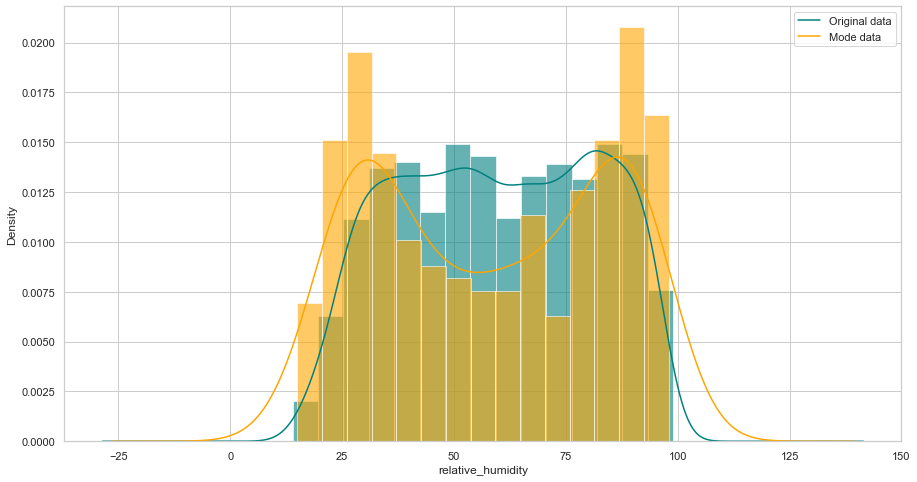

In [59]:
key_to_test = 'relative_humidity'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = relative_humidity_mode[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
relative_humidity_mode[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Mode data'])
ax.set(xlabel=key_to_test)

plt.show()

In [60]:
ks_2samp(weather_data['relative_humidity'], relative_humidity_mode['relative_humidity'])

KstestResult(statistic=0.11411149825783973, pvalue=0.0014066108082868567)

#### median

In [61]:
relative_humidity_median = weather_data.groupby('date_time_local').agg({
  'relative_humidity': lambda x: x.median()
})

relative_humidity_median.describe()

,relative_humidity
count,287.000000
mean,58.599303
std,17.086567
min,20.000000
25%,45.500000
50%,57.500000
75%,70.000000
max,96.000000


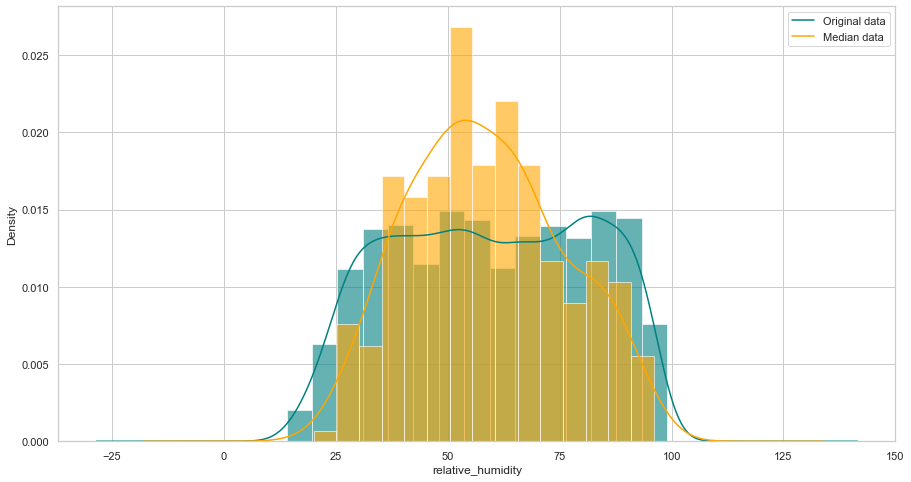

In [62]:
key_to_test = 'relative_humidity'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = relative_humidity_median[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
relative_humidity_median[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Median data'])
ax.set(xlabel=key_to_test)

plt.show()

In [63]:
ks_2samp(weather_data['relative_humidity'], relative_humidity_median['relative_humidity'])

KstestResult(statistic=0.12238675958188153, pvalue=0.0004733083818193595)

Grouping relative_humidty will introduce bias in the dataset so it will be ignored

## Dew_point

In [64]:
weather_data['dew_point'].describe()

count    6887.000000
mean        6.749397
std         4.366163
min        -9.800000
25%         3.400000
50%         7.000000
75%        10.200000
max        18.500000
Name: dew_point, dtype: float64

#### mean

In [65]:
dew_point_mean = weather_data.groupby('date_time_local').agg({
  'dew_point': lambda x: round(x.mean(),1)
})

dew_point_mean.describe()

,dew_point
count,287.000000
mean,6.747735
std,3.995800
min,-4.800000
25%,3.900000
50%,7.000000
75%,10.000000
max,15.200000


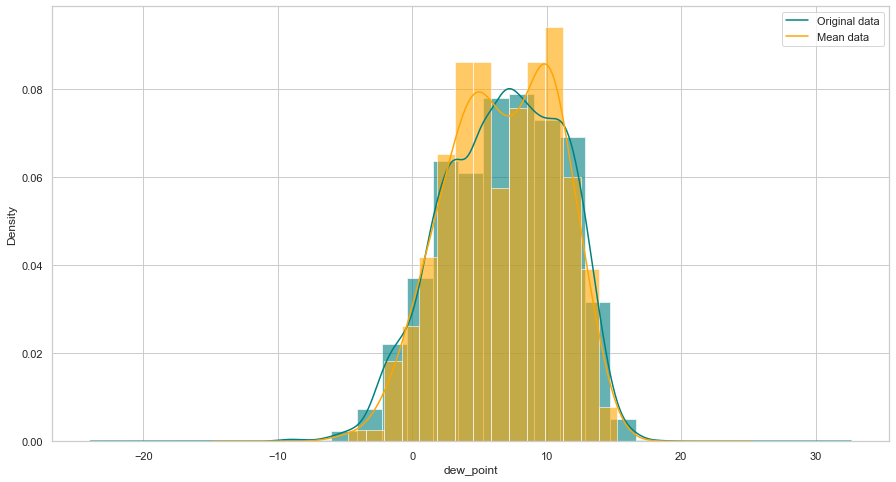

In [66]:
key_to_test = 'dew_point'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = dew_point_mean[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
dew_point_mean[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Mean data'])
ax.set(xlabel=key_to_test)

plt.show()

In [67]:
ks_2samp(weather_data['dew_point'], dew_point_mean['dew_point'])

KstestResult(statistic=0.04819976771196283, pvalue=0.5294554492717671)

#### mode

In [68]:
dew_point_mode = weather_data.groupby('date_time_local').agg({
  'dew_point': lambda x: x.value_counts().index[0]
})

dew_point_mode.describe()

,dew_point
count,287.000000
mean,6.999652
std,4.215692
min,-4.800000
25%,3.500000
50%,7.100000
75%,10.550000
max,15.600000


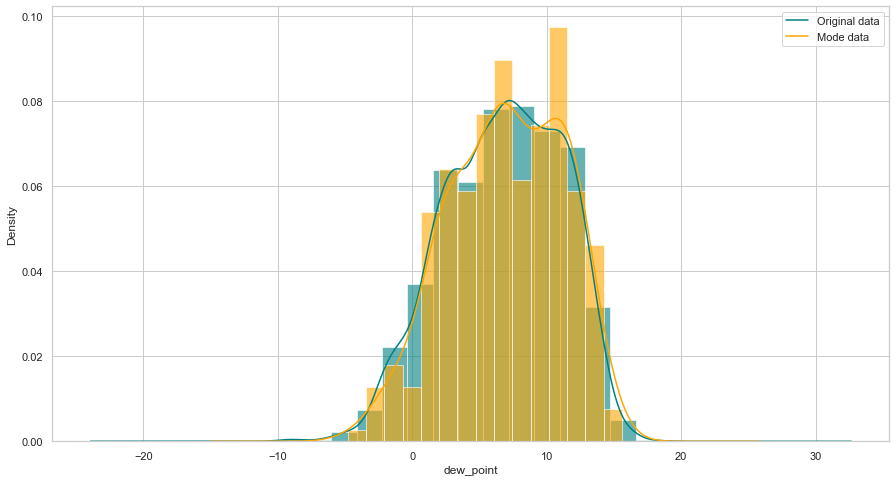

In [69]:
key_to_test = 'dew_point'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = dew_point_mode[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
dew_point_mode[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Mode data'])
ax.set(xlabel=key_to_test)

plt.show()

In [70]:
ks_2samp(weather_data['dew_point'], dew_point_mode['dew_point'])

KstestResult(statistic=0.041957026713124276, pvalue=0.7022641035223791)

#### median

In [71]:
dew_point_median = weather_data.groupby('date_time_local').agg({
  'dew_point': lambda x: x.median()
})

dew_point_median.describe()

,dew_point
count,287.000000
mean,6.780662
std,4.085768
min,-4.200000
25%,3.725000
50%,7.000000
75%,10.050000
max,15.100000


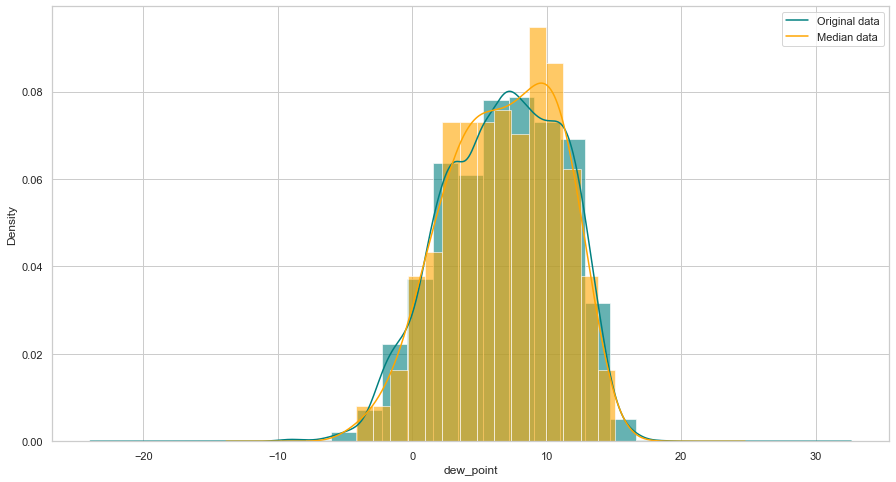

In [72]:
key_to_test = 'dew_point'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = dew_point_median[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
dew_point_median[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Median data'])
ax.set(xlabel=key_to_test)

plt.show()

In [73]:
ks_2samp(weather_data['dew_point'], dew_point_median['dew_point'])

KstestResult(statistic=0.041085946573751454, pvalue=0.7263106947686655)

Mode will be used for dew_point

## Temperature

In [74]:
weather_data['temperature'].describe()

count    6887.000000
mean       15.785088
std         6.388398
min        -1.700000
25%        11.700000
50%        15.800000
75%        20.300000
max        34.300000
Name: temperature, dtype: float64

#### mean

In [75]:
temperature_mean = weather_data.groupby('date_time_local').agg({
  'temperature': lambda x: round(x.mean(),1)
})

temperature_mean.describe()

,temperature
count,287.000000
mean,15.786411
std,5.010938
min,-0.500000
25%,13.500000
50%,16.500000
75%,19.500000
max,25.400000


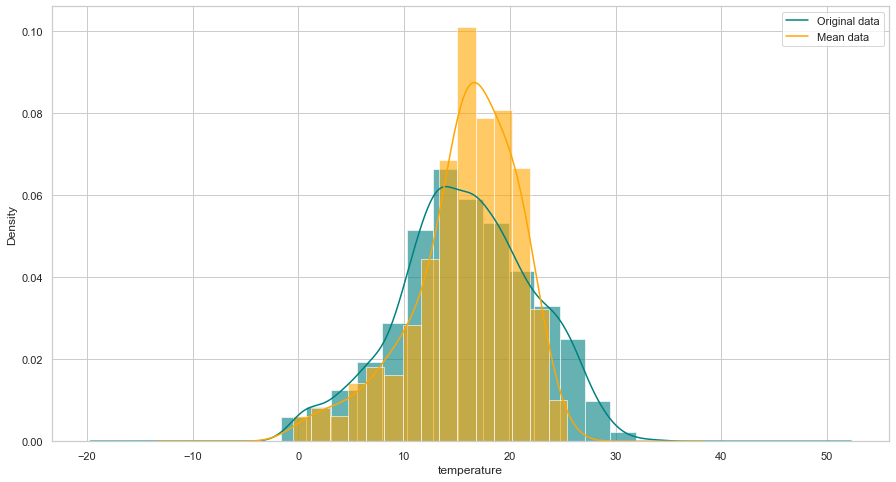

In [76]:
key_to_test = 'temperature'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = temperature_mean[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
temperature_mean[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Mean data'])
ax.set(xlabel=key_to_test)

plt.show()

In [77]:
ks_2samp(weather_data['temperature'], temperature_mean['temperature'])

KstestResult(statistic=0.11977351916376307, pvalue=0.0006731712111454069)

#### mode

In [78]:
temperature_mode = weather_data.groupby('date_time_local').agg({
  'temperature': lambda x: x.value_counts().index[0]
})

temperature_mode.describe()

,temperature
count,287.000000
mean,15.369686
std,6.863796
min,-1.500000
25%,11.000000
50%,15.000000
75%,19.800000
max,31.800000


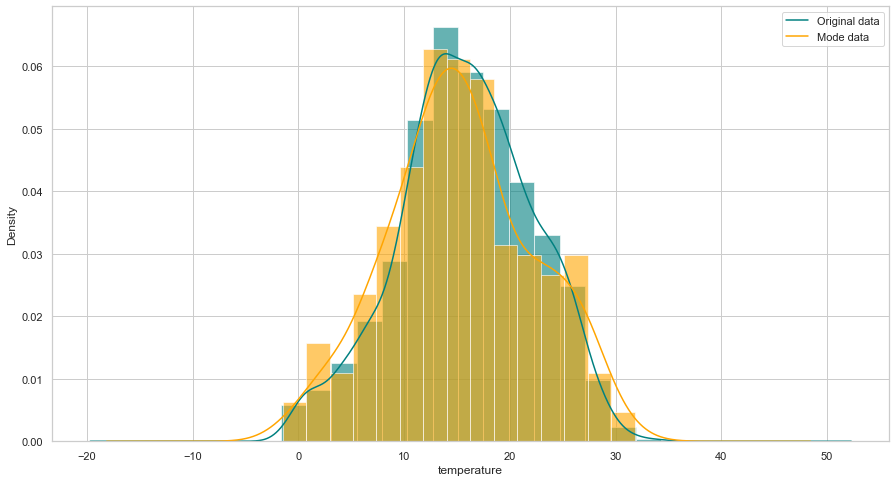

In [79]:
key_to_test = 'temperature'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = temperature_mode[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
temperature_mode[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Mode data'])
ax.set(xlabel=key_to_test)

plt.show()

In [80]:
ks_2samp(weather_data['temperature'], temperature_mode['temperature'])

KstestResult(statistic=0.05734610917537747, pvalue=0.3141646567043528)

#### median

In [81]:
temperature_median = weather_data.groupby('date_time_local').agg({
  'temperature': lambda x: x.median()
})

temperature_median.describe()

,temperature
count,287.000000
mean,15.882578
std,5.206690
min,-0.550000
25%,13.550000
50%,16.500000
75%,19.600000
max,26.250000


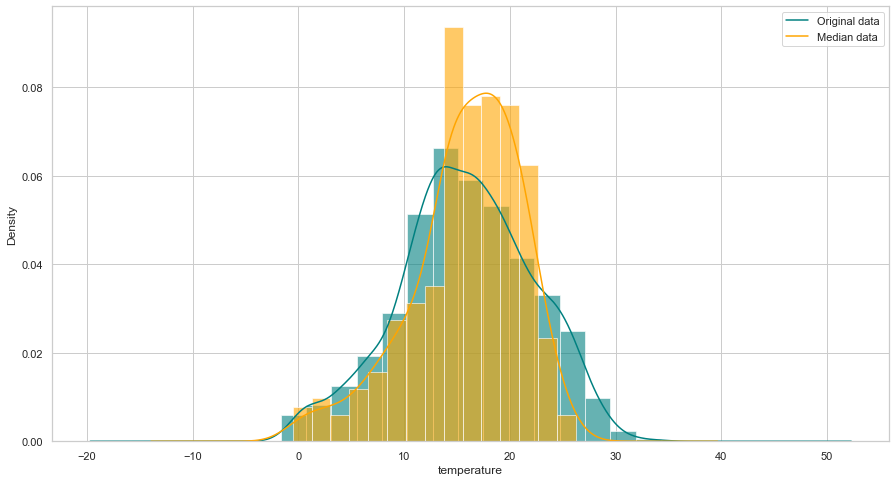

In [82]:
key_to_test = 'temperature'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = temperature_median[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
temperature_median[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Median data'])
ax.set(xlabel=key_to_test)

plt.show()

In [83]:
ks_2samp(weather_data['temperature'], temperature_median['temperature'])

KstestResult(statistic=0.11846689895470383, pvalue=0.000800512778900142)

Mode will be used for temperature

## Health_index

In [84]:
weather_data['health_index'].describe()

count    6838.000000
mean        2.601843
std         1.215754
min         1.000000
25%         1.900000
50%         2.400000
75%         3.000000
max        11.000000
Name: health_index, dtype: float64

#### mean

In [85]:
health_index_mean = weather_data.groupby('date_time_local').agg({
  'health_index': lambda x: round(x.mean(),1)
})

health_index_mean.describe()

,health_index
count,287.000000
mean,2.599303
std,1.006170
min,1.000000
25%,2.000000
50%,2.400000
75%,2.900000
max,7.900000


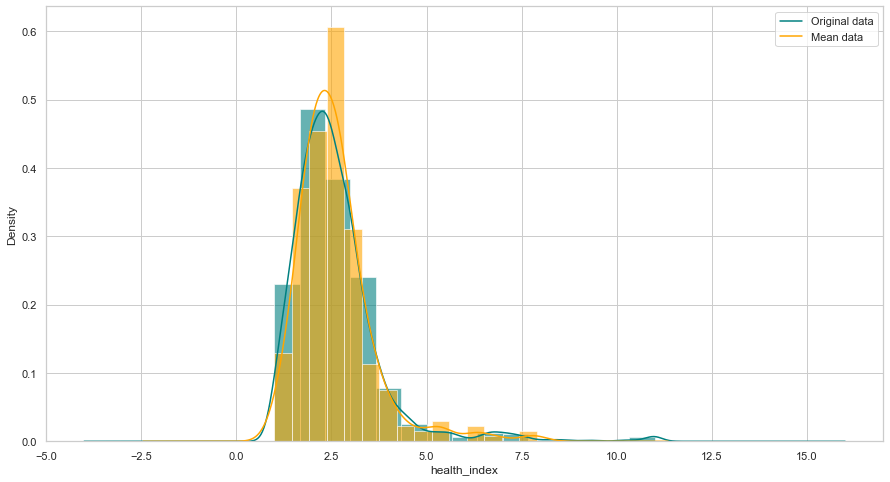

In [86]:
key_to_test = 'health_index'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = health_index_mean[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
health_index_mean[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Mean data'])
ax.set(xlabel=key_to_test)

plt.show()

In [87]:
ks_2samp(weather_data['health_index'], health_index_mean['health_index'])

KstestResult(statistic=0.0624274099883856, pvalue=0.22445342305873173)

#### mode

In [88]:
health_index_mode = weather_data.groupby('date_time_local').agg({
  'health_index': lambda x: x.value_counts().index[0]
})

health_index_mode.describe()

,health_index
count,287.000000
mean,2.504530
std,1.212845
min,1.000000
25%,1.900000
50%,2.300000
75%,2.900000
max,11.000000


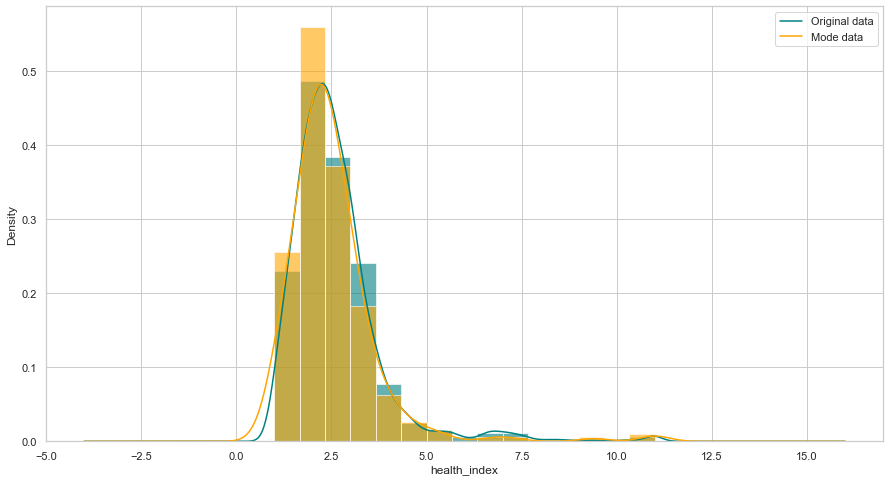

In [89]:
key_to_test = 'health_index'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = health_index_mode[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
health_index_mode[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Mode data'])
ax.set(xlabel=key_to_test)

plt.show()

In [90]:
ks_2samp(weather_data['health_index'], health_index_mode['health_index'])

KstestResult(statistic=0.06997677119628339, pvalue=0.12886557381748565)

#### median

In [91]:
health_index_median = weather_data.groupby('date_time_local').agg({
  'health_index': lambda x: x.median()
})

health_index_median.describe()

,health_index
count,287.000000
mean,2.521080
std,0.959895
min,1.000000
25%,1.950000
50%,2.400000
75%,2.900000
max,7.650000


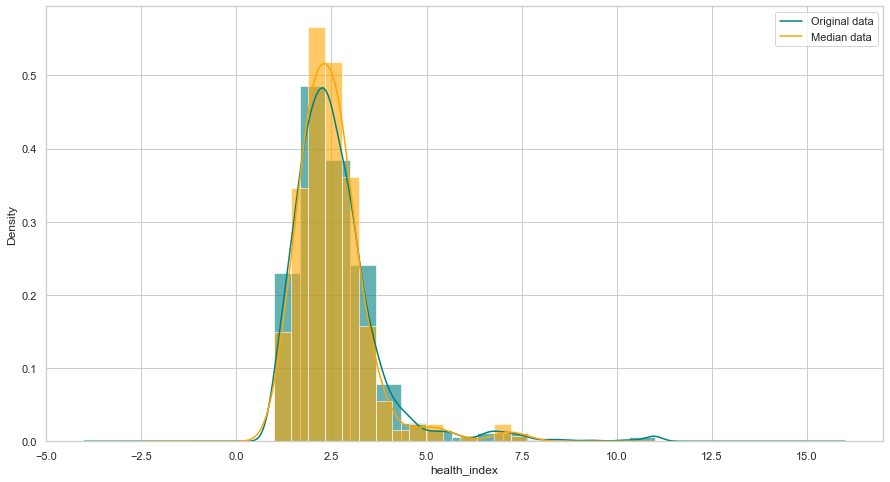

In [92]:
key_to_test = 'health_index'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = health_index_median[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
health_index_median[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Median data'])
ax.set(xlabel=key_to_test)

plt.show()

In [93]:
ks_2samp(weather_data['health_index'], health_index_median['health_index'])

KstestResult(statistic=0.06692799070847852, pvalue=0.16249631062544045)

Mean will be used for health_index

## Grouping weather data by date
- Pressure station by mode
- Pressure sea by median
- wind_dir_10s by mode
- wind_speed by mode
- relative_humidty ignored
- dew_point by mode
- temperature by mode
- health_index by mean

In [94]:
weather_data_grouped = weather_data.groupby('date_time_local', as_index=False).agg({
    'pressure_station': lambda x: x.value_counts().index[0],
    'pressure_sea': lambda x: x.median(),
    'wind_dir_10s': lambda x: x.value_counts().index[0],
    'wind_speed': lambda x: x.value_counts().index[0],
    'dew_point': lambda x: x.value_counts().index[0],
    'temperature': lambda x: x.value_counts().index[0],
    'health_index': lambda x: round(x.mean(), 1)
})

print(len(weather_data_grouped.index))

weather_data_grouped.head()

287


,date_time_local,pressure_station,pressure_sea,wind_dir_10s,wind_speed,dew_point,temperature,health_index
0,2017-05-03,93.87,101.50,20.0,7.0,-1.6,18.9,2.8
1,2017-05-04,93.64,101.40,22.0,7.0,1.9,8.4,3.2
2,2017-05-05,92.13,100.25,15.0,13.0,4.6,27.2,2.8
3,2017-05-06,92.68,100.30,28.0,13.0,5.2,14.9,2.4
4,2017-05-07,93.48,101.30,31.0,18.0,-3.0,6.3,2.2


In [95]:
weather_data_grouped.isnull().sum()

date_time_local     0
pressure_station    0
pressure_sea        0
wind_dir_10s        0
wind_speed          0
dew_point           0
temperature         0
health_index        0
dtype: int64

#### Further group weather data by week

- Because each data set reflects the mosquito activity of the week previous to the collection date. (from https://data.edmonton.ca/Environmental-Services/Mosquito-Trap-Data/dg7f-ubac)

In [96]:
weather_data_grouped.sort_values('date_time_local', inplace=True)
weather_data_grouped.head(7)

,date_time_local,pressure_station,pressure_sea,wind_dir_10s,wind_speed,dew_point,temperature,health_index
0,2017-05-03,93.87,101.50,20.0,7.0,-1.6,18.9,2.8
1,2017-05-04,93.64,101.40,22.0,7.0,1.9,8.4,3.2
2,2017-05-05,92.13,100.25,15.0,13.0,4.6,27.2,2.8
3,2017-05-06,92.68,100.30,28.0,13.0,5.2,14.9,2.4
4,2017-05-07,93.48,101.30,31.0,18.0,-3.0,6.3,2.2
5,2017-05-08,93.54,101.60,31.0,8.0,-4.8,14.0,2.9
6,2017-05-09,93.62,101.60,32.0,7.0,2.1,16.7,2.9


In [97]:
weather_data_grouped = weather_data_grouped.groupby(weather_data_grouped.index // 7).agg({
    'date_time_local': 'last',
    'pressure_station': lambda x: x.value_counts().index[0],
    'pressure_sea': lambda x: x.median(),
    'wind_dir_10s': lambda x: x.value_counts().index[0],
    'wind_speed': lambda x: x.value_counts().index[0],
    'dew_point': lambda x: x.value_counts().index[0],
    'temperature': lambda x: x.value_counts().index[0],
    'health_index': lambda x: round(x.mean(), 1)
})

print(len(weather_data_grouped.index))

41


## Grouping mosquito data


Group by Trap_date and calculate sum of the count, then we can get the number of mosquitoes per week


Add Gender for part B

In [98]:
mos_data.head()

,Trap Date,Genus,Specific Epithet,Gender,Count,Trap Region,Comparison Group,Latitude,Longitude,Location
7163,2017-05-09,Culiseta,alaskaensis,Female,2,Outer Community-South1,Outer,53.333327,-113.531374,POINT (-113.5313737 53.3333269)
9856,2017-05-09,Culiseta,spp.,Female,2,River Valley-East-P1,Core,53.581417,-113.374561,POINT (-113.3745611 53.58141700000001)
19436,2017-05-09,Culiseta,alaskaensis,Female,2,Rural-South West,Peripheral,53.528587,-113.738070,POINT (-113.7380701 53.5285872)
17781,2017-05-09,Culiseta,inornata,Female,1,Rural-North West,Peripheral,53.619232,-113.712798,POINT (-113.7127984 53.6192317)
8338,2017-05-09,Culiseta,incidens,Female,1,Rural-North West,Peripheral,53.619232,-113.712798,POINT (-113.7127984 53.6192317)


In [99]:
 mos_data_grouped = mos_data.groupby(['Trap Date'], as_index=False).agg({
     'Count' : 'sum',
     #'Genus': lambda x: x.value_counts().index[0],
     #'Gender': lambda x: x.value_counts().index[0]
 })

#mos_data_grouped = mos_data.groupby(['Trap Date', 'Genus'], as_index=False).agg({
#    'Count' : 'sum',
#    'Gender': lambda x: x.value_counts().index[0],
#    'Specific Epithet': lambda x: x.value_counts().index[0],
#})

print(len(mos_data_grouped.index))

mos_data_grouped.head()

41


,Trap Date,Count
0,2017-05-09,26
1,2017-05-16,29
2,2017-05-23,523
3,2017-05-30,363
4,2017-06-06,1656


In [100]:
merged_data = pd.merge(left=mos_data_grouped, right=weather_data_grouped, left_on='Trap Date', right_on='date_time_local')

print(len(merged_data.index))

merged_data.drop(columns=['date_time_local'], inplace=True) #redundent

merged_data.head()

41


,Trap Date,Count,pressure_station,pressure_sea,wind_dir_10s,wind_speed,dew_point,temperature,health_index
0,2017-05-09,26,93.87,101.40,31.0,7.0,5.2,6.3,2.7
1,2017-05-16,29,92.94,100.90,11.0,12.0,5.3,2.4,2.4
2,2017-05-23,523,92.37,101.90,20.0,6.0,5.1,22.9,2.5
3,2017-05-30,363,93.31,101.30,15.0,21.0,5.3,11.0,2.5
4,2017-06-06,1656,93.81,101.05,31.0,12.0,7.7,11.8,2.8


In [101]:
merged_data.isnull().sum()

Trap Date           0
Count               0
pressure_station    0
pressure_sea        0
wind_dir_10s        0
wind_speed          0
dew_point           0
temperature         0
health_index        0
dtype: int64

## Add features
- isWarm: if temperature is above 20 = 1, else = 0.
- add genusCat for Genus
- add genderCat female = 1, male = 0
- add delta_pressure = pressure_station - pressure_sea

In [102]:
merged_data['isWarm'] = np.where(merged_data['temperature'] >= 20, 1, 0)

In [103]:
merged_data['isWindy'] = np.where(merged_data['wind_speed'] >= 25, 1, 0)

In [104]:
merged_data["delta_pressure"] = merged_data.apply(lambda x: x['pressure_station'] - x['pressure_sea'], axis=1)

In [105]:
merged_data

,Trap Date,Count,pressure_station,pressure_sea,wind_dir_10s,wind_speed,dew_point,temperature,health_index,isWarm,isWindy,delta_pressure
0,2017-05-09,26,93.87,101.400,31.0,7.0,5.2,6.3,2.7,0,0,-7.530
1,2017-05-16,29,92.94,100.900,11.0,12.0,5.3,2.4,2.4,0,0,-7.960
2,2017-05-23,523,92.37,101.900,20.0,6.0,5.1,22.9,2.5,1,0,-9.530
3,2017-05-30,363,93.31,101.300,15.0,21.0,5.3,11.0,2.5,0,0,-7.990
4,2017-06-06,1656,93.81,101.050,31.0,12.0,7.7,11.8,2.8,0,0,-7.240
5,2017-06-13,2969,91.87,100.850,34.0,11.0,6.6,15.1,2.5,0,0,-8.980
6,2017-06-20,1872,93.41,100.900,29.0,17.0,10.0,12.7,2.3,0,0,-7.490
7,2017-06-27,769,94.46,102.100,31.0,17.0,7.7,19.3,2.4,0,0,-7.640
8,2017-07-04,1779,93.53,101.300,20.0,7.0,6.6,18.3,2.3,0,0,-7.770
9,2017-07-11,2253,93.92,101.600,12.0,15.0,12.6,16.9,2.8,0,0,-7.680


In [106]:
len(merged_data)

41

# Part A: Linear Regression for no_of_Mosquito = function(weather_features_A)

<AxesSubplot:xlabel='Count', ylabel='Density'>

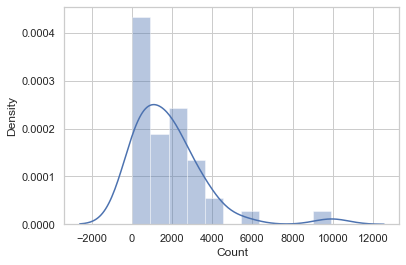

In [107]:
sns.distplot(merged_data['Count'])

In [108]:
merged_data['Count'].describe()

count      41.000000
mean     1814.268293
std      1833.500028
min        26.000000
25%       523.000000
50%      1656.000000
75%      2209.000000
max      9938.000000
Name: Count, dtype: float64

In [109]:
#merged_data = merged_data[merged_data['Count'] < merged_data['Count'].describe()['75%']]  

<AxesSubplot:>

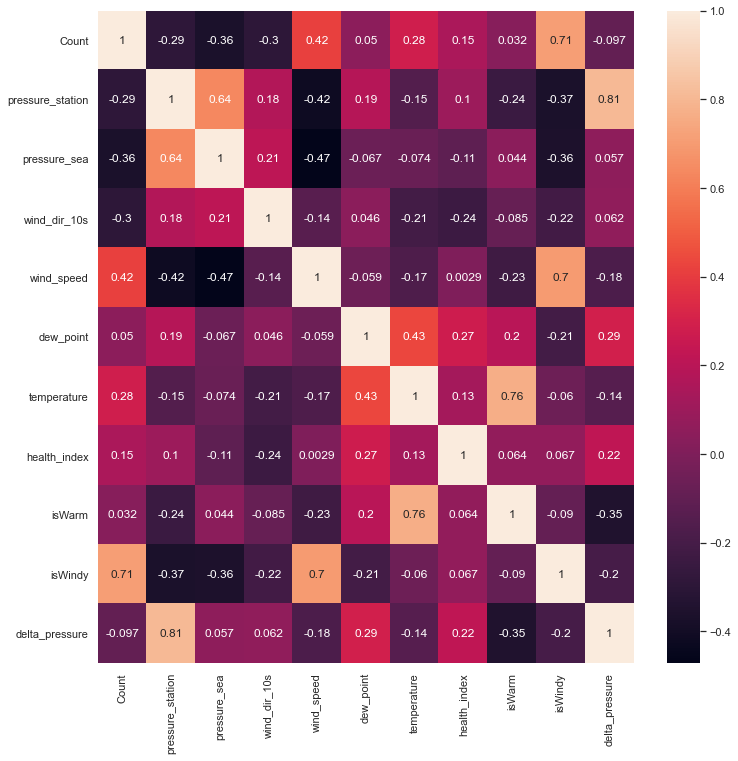

In [110]:
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(merged_data.corr(), annot=True, ax=ax)

In [111]:
x_cols = ['wind_speed', 'temperature', 'health_index', 'isWindy']
X = merged_data[x_cols]
y = merged_data['Count']

In [112]:
from sklearn.preprocessing import StandardScaler

#x_cols = ['temperature', 'wind_speed', 'health_index']


X_stand = X.copy()
X_norm = X.copy()
X_both = X.copy()

X_stand[x_cols] = StandardScaler().fit_transform(X[x_cols])
X_norm[x_cols] = X[x_cols].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
X_both[x_cols] = StandardScaler().fit_transform(X[x_cols].apply(lambda x: (x - x.min()) / (x.max() - x.min()))[x_cols])

In [113]:
X_stand.head()

,wind_speed,temperature,health_index,isWindy
0,-0.617413,-1.182044,0.140805,-0.158114
1,0.220797,-1.720531,-0.281609,-0.158114
2,-0.785054,1.109976,-0.140805,-0.158114
3,1.729573,-0.533098,-0.140805,-0.158114
4,0.220797,-0.422640,0.281609,-0.158114


In [114]:
X_norm.head()

,wind_speed,temperature,health_index,isWindy
0,0.090909,0.223827,0.318182,0.0
1,0.242424,0.083032,0.250000,0.0
2,0.060606,0.823105,0.272727,0.0
3,0.515152,0.393502,0.272727,0.0
4,0.242424,0.422383,0.340909,0.0


In [115]:
from sklearn.model_selection import train_test_split

test_size = 0.3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
X_train_stand, X_test_stand, y_train_stand, y_test_stand = train_test_split(X_stand, y, test_size=test_size, random_state=42)
X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(X_norm, y, test_size=test_size, random_state=42)
X_train_both, X_test_both, y_train_both, y_test_both = train_test_split(X_both, y, test_size=test_size, random_state=42)


In [116]:
y_train.head()

9     2253
15    3948
32    2195
16    3855
35    1134
Name: Count, dtype: int64

In [117]:
y_train_stand.head()

9     2253
15    3948
32    2195
16    3855
35    1134
Name: Count, dtype: int64

In [118]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

def cross_val(model):
    pred = cross_val_score(model, X, y, cv=10)
    return pred.mean()

def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

In [119]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)

lin_reg_norm = LinearRegression()
lin_reg_norm.fit(X_train_norm,y_train_norm)

lin_reg_stand = LinearRegression()
lin_reg_stand.fit(X_train_stand,y_train_stand)

lin_reg_both = LinearRegression()
lin_reg_both.fit(X_train_both,y_train_both)

LinearRegression()

In [120]:
print(lin_reg.intercept_)
coeff_df = pd.DataFrame(lin_reg.coef_, X.columns, columns=['Coefficient'])
coeff_df

-233.26717985636947


,Coefficient
wind_speed,-1.930629
temperature,78.869395
health_index,224.283255
isWindy,0.000000


In [121]:
print(lin_reg_norm.intercept_)
coeff_df = pd.DataFrame(lin_reg_norm.coef_, X.columns, columns=['Coefficient'])
coeff_df

58.46547565626406


,Coefficient
wind_speed,-63.710756
temperature,2184.682244
health_index,986.846323
isWindy,0.000000


In [122]:
print(lin_reg_stand.intercept_)
coeff_df = pd.DataFrame(lin_reg_stand.coef_, X.columns, columns=['Coefficient'])
coeff_df

1501.320672859954


,Coefficient
wind_speed,-1.151639e+01
temperature,5.712131e+02
health_index,1.592869e+02
isWindy,5.149693e-29


In [123]:
print(lin_reg_both.intercept_)
coeff_df = pd.DataFrame(lin_reg_both.coef_, X.columns, columns=['Coefficient'])
coeff_df

1501.320672859954


,Coefficient
wind_speed,-1.151639e+01
temperature,5.712131e+02
health_index,1.592869e+02
isWindy,-2.395759e-29


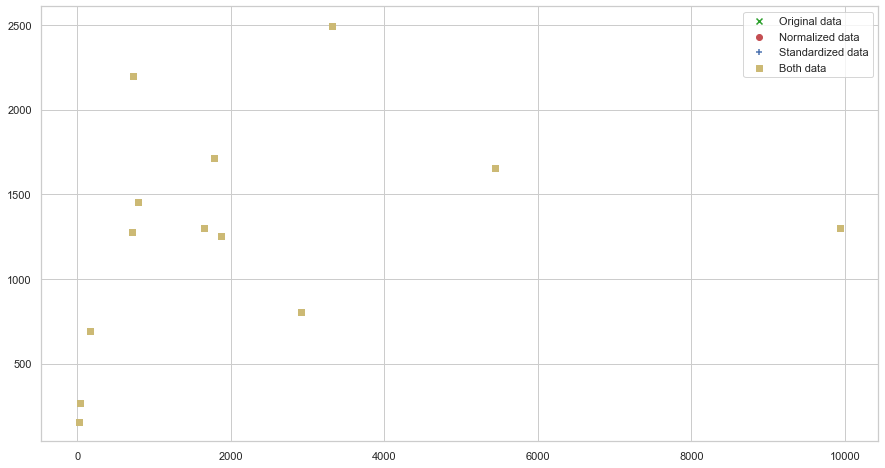

In [124]:
pred = lin_reg.predict(X_test)
pred_norm = lin_reg_norm.predict(X_test_norm)
pred_stand = lin_reg_stand.predict(X_test_stand)
pred_both = lin_reg_both.predict(X_test_both)


plt.figure(figsize=(15, 8))
ax = plt.gca()

ax.scatter(y_test, pred, c='#2ca02c', marker='x', label='Original data')
ax.scatter(y_test_norm, pred, c='r', marker='o', label='Normalized data')
ax.scatter(y_test_stand, pred, c='b', marker='+', label='Standardized data')
ax.scatter(y_test_both, pred, c='y', marker='s', label='Both data')

plt.legend(loc='best');

plt.show()

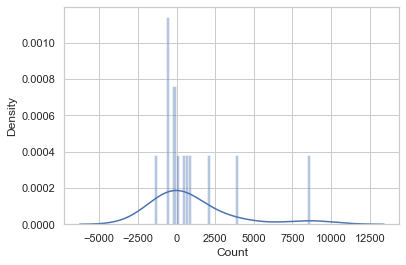

In [125]:
sns.distplot((y_test - pred), bins=50);

In [126]:
test_pred = lin_reg.predict(X_test)
train_pred = lin_reg.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

Test set evaluation:
_____________________________________
MAE: 1537.9823018470884
MSE: 7534140.728400628
RMSE: 2744.838925766069
R2 Square -0.05736571519539746
Train set evaluation:
_____________________________________
MAE: 833.5648973585481
MSE: 1039005.443193853
RMSE: 1019.3161644915933
R2 Square 0.23524657148233108


In [127]:
test_pred_norm = lin_reg_norm.predict(X_test_norm)
train_pred_norm = lin_reg_norm.predict(X_train_norm)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test_norm, test_pred_norm)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train_norm, train_pred_norm)

Test set evaluation:
_____________________________________
MAE: 1537.9823018470884
MSE: 7534140.728400628
RMSE: 2744.838925766069
R2 Square -0.05736571519539746
Train set evaluation:
_____________________________________
MAE: 833.5648973585479
MSE: 1039005.4431938528
RMSE: 1019.3161644915932
R2 Square 0.2352465714823313


In [128]:
test_pred_stand = lin_reg_stand.predict(X_test_stand)
train_pred_stand = lin_reg_stand.predict(X_train_stand)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test_stand, test_pred_stand)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train_stand, train_pred_stand)

Test set evaluation:
_____________________________________
MAE: 1537.9823018470884
MSE: 7534140.728400628
RMSE: 2744.838925766069
R2 Square -0.05736571519539746
Train set evaluation:
_____________________________________
MAE: 833.5648973585481
MSE: 1039005.4431938528
RMSE: 1019.3161644915932
R2 Square 0.2352465714823313


In [129]:
test_pred_both = lin_reg_both.predict(X_test_both)
train_pred_both = lin_reg_both.predict(X_train_both)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test_both, test_pred_both)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train_both, train_pred_both)

Test set evaluation:
_____________________________________
MAE: 1537.982301847088
MSE: 7534140.728400626
RMSE: 2744.8389257660688
R2 Square -0.057365715195397016
Train set evaluation:
_____________________________________
MAE: 833.5648973585479
MSE: 1039005.4431938529
RMSE: 1019.3161644915933
R2 Square 0.2352465714823312


In [130]:
results_df = pd.DataFrame(data=[["Linear Regression", *evaluate(y_test, test_pred) , cross_val(LinearRegression())], ["Linear Regression w/ norm", *evaluate(y_test_norm, test_pred_norm) , cross_val(LinearRegression())], ["Linear Regression w/ stand", *evaluate(y_test_stand, test_pred_stand) , cross_val(LinearRegression())],["Linear Regression w/ both", *evaluate(y_test_both, test_pred_both) , cross_val(LinearRegression())]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,1537.982302,7.534141e+06,2744.838926,-0.057366,-3.071474
1,Linear Regression w/ norm,1537.982302,7.534141e+06,2744.838926,-0.057366,-3.071474
2,Linear Regression w/ stand,1537.982302,7.534141e+06,2744.838926,-0.057366,-3.071474
3,Linear Regression w/ both,1537.982302,7.534141e+06,2744.838926,-0.057366,-3.071474


# Part B: count depending on Gender

In [131]:
#mos_data_grouped_B = mos_data.groupby(['Trap Date', 'Gender', 'Specific Epithet'], as_index=False).agg({
mos_data_grouped_B = mos_data.groupby(['Trap Date', 'Gender'], as_index=False).agg({
    'Count' : 'sum',
    #'Genus': lambda x: x.value_counts().index[0],
})

print(len(mos_data_grouped_B.index))

mos_data_grouped_B.head()

81


,Trap Date,Gender,Count
0,2017-05-09,Female,26
1,2017-05-16,Female,23
2,2017-05-16,Male,6
3,2017-05-23,Female,198
4,2017-05-23,Male,325


In [132]:
mos_data_grouped_B_females = mos_data_grouped_B[mos_data_grouped_B["Gender"] == "Female"]
mos_data_grouped_B_males = mos_data_grouped_B[mos_data_grouped_B["Gender"] == "Male"]

In [133]:
print(len(mos_data_grouped_B_females.index), len(mos_data_grouped_B_males.index))

41 40


In [134]:
mos_data_grouped_B_females = mos_data_grouped_B_females.groupby(['Trap Date'], as_index=False).agg({
    'Count' : 'sum',
    #'Specific Epithet': lambda x: x.value_counts().index[0],
})
len(mos_data_grouped_B_females.index)

41

In [135]:
mos_data_grouped_B_females.head()

,Trap Date,Count
0,2017-05-09,26
1,2017-05-16,23
2,2017-05-23,198
3,2017-05-30,150
4,2017-06-06,526


## Linear Regression and Polynomial Regression

### no_of_Mosquito_Female = function(weather_features_B)

In [136]:
merged_data_females = pd.merge(left=mos_data_grouped_B_females, right=weather_data_grouped, left_on='Trap Date', right_on='date_time_local')

print(len(merged_data_females.index))

merged_data_females.drop(columns=['date_time_local'], inplace=True) #redundent

merged_data_females.head()

41


,Trap Date,Count,pressure_station,pressure_sea,wind_dir_10s,wind_speed,dew_point,temperature,health_index
0,2017-05-09,26,93.87,101.40,31.0,7.0,5.2,6.3,2.7
1,2017-05-16,23,92.94,100.90,11.0,12.0,5.3,2.4,2.4
2,2017-05-23,198,92.37,101.90,20.0,6.0,5.1,22.9,2.5
3,2017-05-30,150,93.31,101.30,15.0,21.0,5.3,11.0,2.5
4,2017-06-06,526,93.81,101.05,31.0,12.0,7.7,11.8,2.8


<AxesSubplot:xlabel='Count', ylabel='Density'>

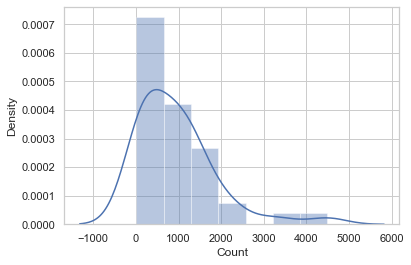

In [137]:
sns.distplot(merged_data_females['Count'])

In [138]:
merged_data_females['isWarm'] = np.where(merged_data_females['temperature'] >= 20, 1, 0)

In [139]:
merged_data_females['isWindy'] = np.where(merged_data_females['wind_speed'] >= 25, 1, 0)

In [140]:
merged_data_females["delta_pressure"] = merged_data_females.apply(lambda x: x['pressure_station'] - x['pressure_sea'], axis=1)

<AxesSubplot:>

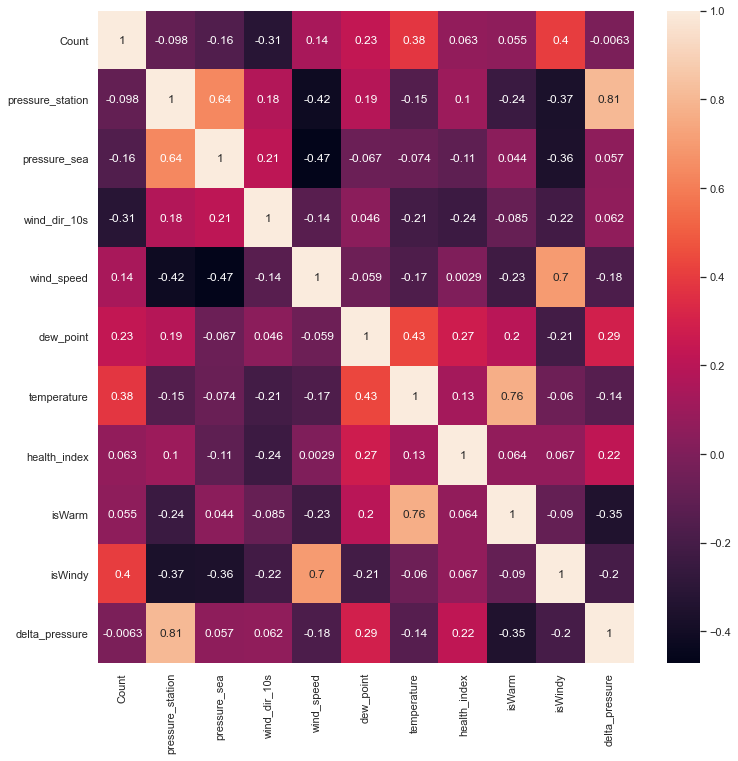

In [141]:
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(merged_data_females.corr(), annot=True, ax=ax)

In [142]:

x_cols = ['wind_dir_10s',  'isWindy', 'temperature']

X = merged_data_females[x_cols]
y = merged_data_females['Count']

In [143]:
from sklearn.preprocessing import StandardScaler

#x_cols = ['temperature']
x_cols = ['wind_dir_10s',  'isWindy', 'temperature']


X_stand = X.copy()
X_norm = X.copy()
X_both = X.copy()

X_stand[x_cols] = StandardScaler().fit_transform(X[x_cols])
X_norm[x_cols] = X[x_cols].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
X_both[x_cols] = StandardScaler().fit_transform(X[x_cols].apply(lambda x: (x - x.min()) / (x.max() - x.min()))[x_cols])

In [144]:
from sklearn.model_selection import train_test_split

test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
X_train_stand, X_test_stand, y_train_stand, y_test_stand = train_test_split(X_stand, y, test_size=test_size, random_state=42)
X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(X_norm, y, test_size=test_size, random_state=42)
X_train_both, X_test_both, y_train_both, y_test_both = train_test_split(X_both, y, test_size=test_size, random_state=42)


In [145]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

def cross_val(model):
    pred = cross_val_score(model, X, y, cv=10)
    return pred.mean()

def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

In [146]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)

lin_reg_norm = LinearRegression()
lin_reg_norm.fit(X_train_norm,y_train_norm)

lin_reg_stand = LinearRegression()
lin_reg_stand.fit(X_train_stand,y_train_stand)

lin_reg_both = LinearRegression()
lin_reg_both.fit(X_train_both,y_train_both)

LinearRegression()

In [147]:
print(lin_reg.intercept_)
coeff_df = pd.DataFrame(lin_reg.coef_, X.columns, columns=['Coefficient'])
coeff_df

383.1175384074204


,Coefficient
wind_dir_10s,-9.447740
isWindy,0.000000
temperature,43.896859


In [148]:
print(lin_reg_norm.intercept_)
coeff_df = pd.DataFrame(lin_reg_norm.coef_, X.columns, columns=['Coefficient'])
coeff_df

283.58208020257575


,Coefficient
wind_dir_10s,-236.193509
isWindy,0.000000
temperature,1215.942992


In [149]:
print(lin_reg_stand.intercept_)
coeff_df = pd.DataFrame(lin_reg_stand.coef_, X.columns, columns=['Coefficient'])
coeff_df

800.42634225566


,Coefficient
wind_dir_10s,-67.846679
isWindy,0.000000
temperature,317.923851


In [150]:
print(lin_reg_both.intercept_)
coeff_df = pd.DataFrame(lin_reg_both.coef_, X.columns, columns=['Coefficient'])
coeff_df

800.42634225566


,Coefficient
wind_dir_10s,-67.846679
isWindy,0.000000
temperature,317.923851


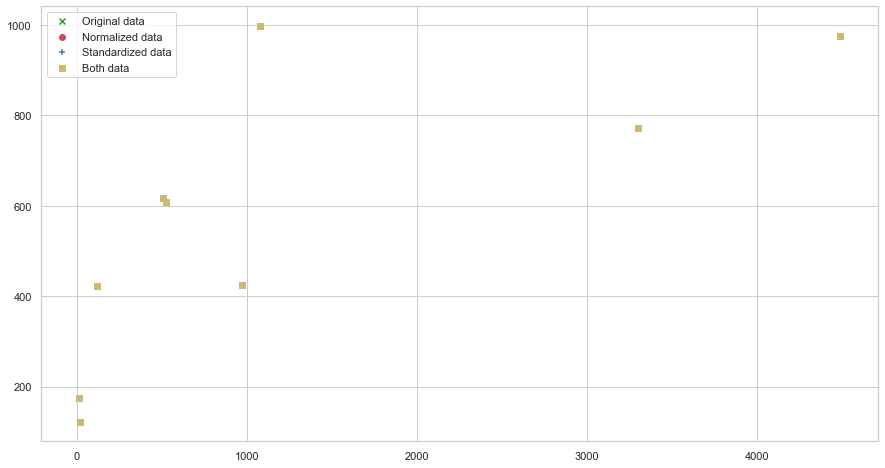

In [151]:
pred = lin_reg.predict(X_test)
pred_norm = lin_reg_norm.predict(X_test_norm)
pred_stand = lin_reg_stand.predict(X_test_stand)
pred_both = lin_reg_both.predict(X_test_both)


plt.figure(figsize=(15, 8))
ax = plt.gca()

ax.scatter(y_test, pred, c='#2ca02c', marker='x', label='Original data')
ax.scatter(y_test_norm, pred_norm, c='r', marker='o', label='Normalized data')
ax.scatter(y_test_stand, pred_stand, c='b', marker='+', label='Standardized data')
ax.scatter(y_test_both, pred_both, c='y', marker='s', label='Both data')

plt.legend(loc='best');

plt.show()

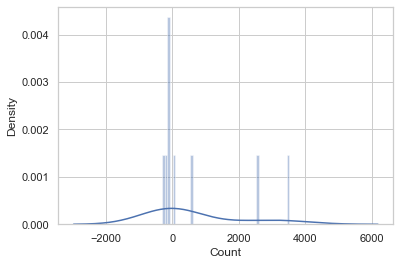

In [152]:
sns.distplot((y_test - pred), bins=50);

In [153]:
test_pred = lin_reg.predict(X_test)
train_pred = lin_reg.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

Test set evaluation:
_____________________________________
MAE: 825.1097933192814
MSE: 2132744.7887890544
RMSE: 1460.3919983309463
R2 Square 0.05018450698387644
Train set evaluation:
_____________________________________
MAE: 460.00337071731644
MSE: 324937.36642872886
RMSE: 570.0327766266856
R2 Square 0.2407548391242359


In [154]:
test_pred_norm = lin_reg_norm.predict(X_test_norm)
train_pred_norm = lin_reg_norm.predict(X_train_norm)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test_norm, test_pred_norm)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train_norm, train_pred_norm)

Test set evaluation:
_____________________________________
MAE: 825.1097933192814
MSE: 2132744.7887890544
RMSE: 1460.3919983309463
R2 Square 0.05018450698387644
Train set evaluation:
_____________________________________
MAE: 460.00337071731644
MSE: 324937.36642872886
RMSE: 570.0327766266856
R2 Square 0.2407548391242359


In [155]:
test_pred_stand = lin_reg_stand.predict(X_test_stand)
train_pred_stand = lin_reg_stand.predict(X_train_stand)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test_stand, test_pred_stand)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train_stand, train_pred_stand)

Test set evaluation:
_____________________________________
MAE: 825.1097933192814
MSE: 2132744.7887890544
RMSE: 1460.3919983309463
R2 Square 0.05018450698387633
Train set evaluation:
_____________________________________
MAE: 460.00337071731644
MSE: 324937.36642872886
RMSE: 570.0327766266856
R2 Square 0.2407548391242359


In [156]:
test_pred_both = lin_reg_both.predict(X_test_both)
train_pred_both = lin_reg_both.predict(X_train_both)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test_both, test_pred_both)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train_both, train_pred_both)

Test set evaluation:
_____________________________________
MAE: 825.1097933192814
MSE: 2132744.7887890544
RMSE: 1460.3919983309463
R2 Square 0.05018450698387633
Train set evaluation:
_____________________________________
MAE: 460.00337071731644
MSE: 324937.36642872886
RMSE: 570.0327766266856
R2 Square 0.2407548391242359


In [157]:
results_df = pd.DataFrame(data=[["Linear Regression", *evaluate(y_test, test_pred) , cross_val(LinearRegression())], ["Linear Regression w/ norm", *evaluate(y_test_norm, test_pred_norm) , cross_val(LinearRegression())], ["Linear Regression w/ stand", *evaluate(y_test_stand, test_pred_stand) , cross_val(LinearRegression())],["Linear Regression w/ both", *evaluate(y_test_both, test_pred_both) , cross_val(LinearRegression())]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,825.109793,2.132745e+06,1460.391998,0.050185,-9.488674
1,Linear Regression w/ norm,825.109793,2.132745e+06,1460.391998,0.050185,-9.488674
2,Linear Regression w/ stand,825.109793,2.132745e+06,1460.391998,0.050185,-9.488674
3,Linear Regression w/ both,825.109793,2.132745e+06,1460.391998,0.050185,-9.488674


## Polynomial Regression
### no_of_Mosquito_Female = function(weather_features_C)

In [158]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest

<AxesSubplot:xlabel='Count', ylabel='Density'>

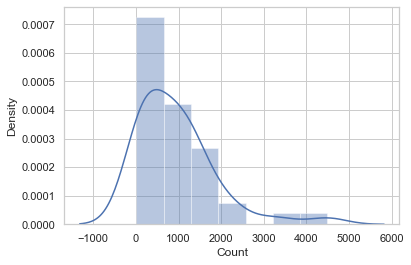

In [159]:
sns.distplot(merged_data_females['Count'])

<AxesSubplot:>

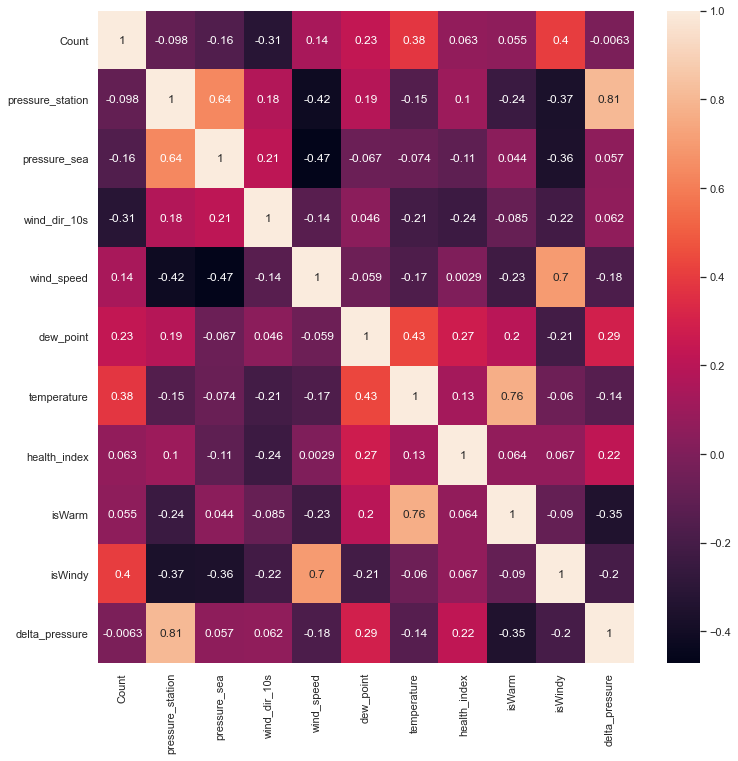

In [160]:
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(merged_data_females.corr(), annot=True, ax=ax)

In [161]:
x_cols = [ 'wind_speed','dew_point' ,'temperature', 'isWindy']
X = merged_data_females[x_cols]
y = merged_data_females['Count']

In [162]:
def compute_mse(X_train, Y_train, X_test, Y_test, n_degree=11):
    train_mse = []
    test_mse = []
    for degree in range(1,n_degree):
        poly_features = PolynomialFeatures(degree=degree)
        sklreg = LinearRegression()
        pipeline = Pipeline([("polynomial_features", poly_features),
                             ("linear_regression", sklreg)])
        pipeline.fit(X_train, Y_train)
        Y_train_pred = pipeline.predict(X_train)
        Y_test_pred = pipeline.predict(X_test)

        train_mse.append(mean_squared_error(Y_train, Y_train_pred))
        test_mse.append(mean_squared_error(Y_test, Y_test_pred))
    return train_mse,test_mse

In [163]:
from sklearn.preprocessing import StandardScaler

x_cols = [ 'wind_speed','dew_point' ,'temperature', 'isWindy']


X_stand = X.copy()
X_norm = X.copy()
X_both = X.copy()

X_stand[x_cols] = StandardScaler().fit_transform(X[x_cols])
X_norm[x_cols] = X[x_cols].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
X_both[x_cols] = StandardScaler().fit_transform(X[x_cols].apply(lambda x: (x - x.min()) / (x.max() - x.min()))[x_cols])

In [164]:
from sklearn.model_selection import train_test_split

test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
X_train_stand, X_test_stand, y_train_stand, y_test_stand = train_test_split(X_stand, y, test_size=test_size, random_state=42)
X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(X_norm, y, test_size=test_size, random_state=42)
X_train_both, X_test_both, y_train_both, y_test_both = train_test_split(X_both, y, test_size=test_size, random_state=42)

In [165]:
train_mse,test_mse = compute_mse(X_train,y_train,X_test,y_test)
train_mse_stand,test_mse_stand, = compute_mse(X_train_stand,y_train_stand,X_test_stand,y_test_stand)
train_mse_norm,test_mse_norm = compute_mse(X_train_norm,y_train_norm,X_test_norm,y_test_norm)
train_mse_both,test_mse_both = compute_mse(X_train_both,y_train_both,X_test_both,y_test_both)

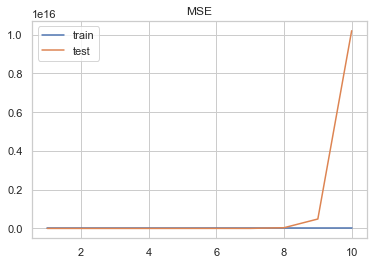

In [166]:
plt.plot(range(1,len(train_mse)+1),train_mse, label='train')
plt.plot(range(1,len(test_mse)+1),test_mse, label='test')
plt.title('MSE')
plt.legend()

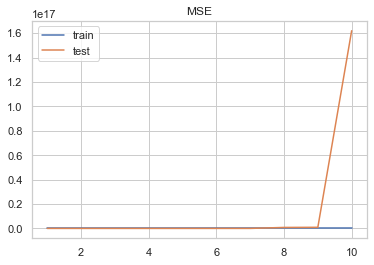

In [167]:
plt.plot(range(1,len(train_mse_stand)+1),train_mse_stand, label='train')
plt.plot(range(1,len(test_mse_stand)+1),test_mse_stand, label='test')
plt.title('MSE')
plt.legend()

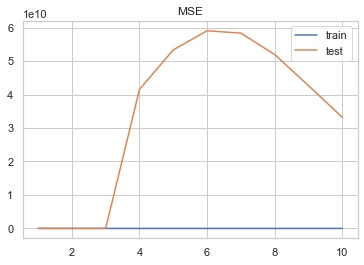

In [168]:
plt.plot(range(1,len(train_mse_norm)+1),train_mse_norm, label='train')
plt.plot(range(1,len(test_mse_norm)+1),test_mse_norm, label='test')
plt.title('MSE')
plt.legend()

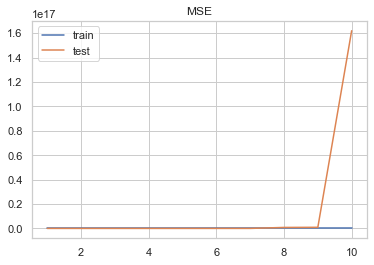

In [169]:
plt.plot(range(1,len(train_mse_both)+1),train_mse_both, label='train')
plt.plot(range(1,len(test_mse_both)+1),test_mse_both, label='test')
plt.title('MSE')
plt.legend()

In [170]:
print("Best degree none: ",np.argmin(train_mse)+1)
print("Best degree standarization: ",np.argmin(train_mse_stand)+1)
print("Best degree normalization: ",np.argmin(train_mse_norm)+1)
print("Best degree both: ",np.argmin(train_mse_both)+1)

Best degree none:  5
Best degree standarization:  5
Best degree normalization:  10
Best degree both:  4


In [171]:
poly_features = PolynomialFeatures(degree=np.argmin(train_mse)+1, include_bias=False)
X_poly = poly_features.fit_transform(X)

poly_features_stand = PolynomialFeatures(degree=np.argmin(train_mse_stand )+1, include_bias=False)
X_poly_stand = poly_features_stand.fit_transform(X_stand)

poly_features_norm = PolynomialFeatures(degree=np.argmin(train_mse_norm)+1, include_bias=False)
X_poly_norm = poly_features_norm.fit_transform(X_norm)

poly_features_both = PolynomialFeatures(degree=np.argmin(train_mse_both)+1, include_bias=False)
X_poly_both = poly_features_both.fit_transform(X_both)

In [172]:
X_best = SelectKBest(f_regression,5).fit_transform(X_poly, y)
X_best_stand = SelectKBest(f_regression,5).fit_transform(X_poly_stand, y)
X_best_norm = SelectKBest(f_regression,5).fit_transform(X_poly_norm, y)
X_best_both = SelectKBest(f_regression,5).fit_transform(X_poly_both, y)

In [181]:
X_best.shape, X_best_stand.shape, X_best_norm.shape, X_best_both.shape

((41, 5), (41, 5), (41, 5), (41, 5))

In [173]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_best,y)

lin_reg_norm = LinearRegression()
lin_reg_norm.fit(X_best_norm,y)

lin_reg_stand = LinearRegression()
lin_reg_stand.fit(X_best_stand,y)

lin_reg_both = LinearRegression()
lin_reg_both.fit(X_best_both,y)

LinearRegression()

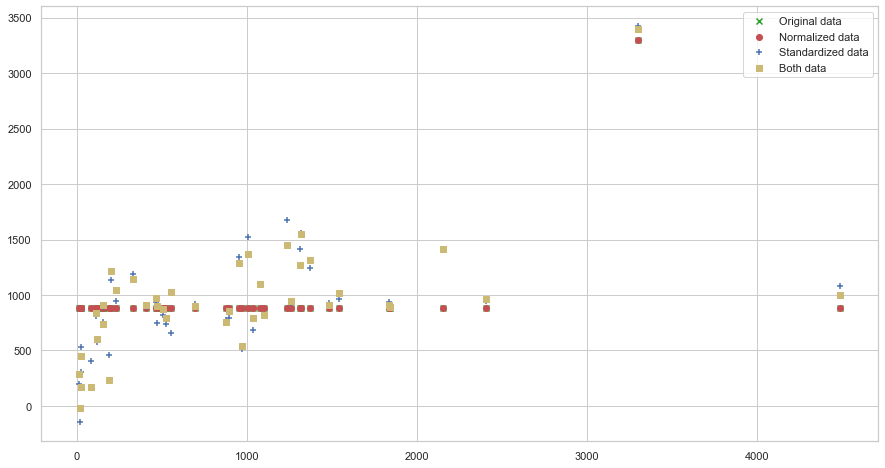

In [174]:
pred = lin_reg.predict(X_best)
pred_norm = lin_reg_norm.predict(X_best_norm)
pred_stand = lin_reg_stand.predict(X_best_stand)
pred_both = lin_reg_both.predict(X_best_both)


plt.figure(figsize=(15, 8))
ax = plt.gca()

ax.scatter(y, pred, c='#2ca02c', marker='x', label='Original data')
ax.scatter(y, pred_norm, c='r', marker='o', label='Normalized data')
ax.scatter(y, pred_stand, c='b', marker='+', label='Standardized data')
ax.scatter(y, pred_both, c='y', marker='s', label='Both data')

plt.legend(loc='best');

plt.show()

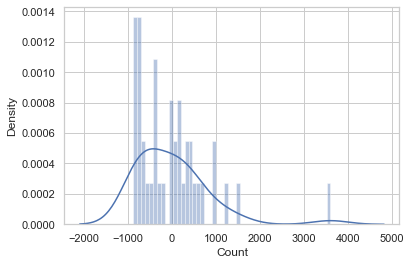

In [175]:
sns.distplot((y - pred), bins=50);

In [176]:
print('Train set evaluation:\n_____________________________________')
print_evaluate(y, pred)

Train set evaluation:
_____________________________________
MAE: 607.5085365853658
MSE: 710113.3115853658
RMSE: 842.6822126907425
R2 Square 0.16354846077141938


In [177]:
print('Train set evaluation:\n_____________________________________')
print_evaluate(y, pred_norm)

Train set evaluation:
_____________________________________
MAE: 607.508536585366
MSE: 710113.3115853658
RMSE: 842.6822126907425
R2 Square 0.16354846077141938


In [178]:
print('Train set evaluation:\n_____________________________________')
print_evaluate(y, pred_stand)

Train set evaluation:
_____________________________________
MAE: 513.5928066310911
MSE: 562201.4154668949
RMSE: 749.8009172219615
R2 Square 0.33777577232863965


In [179]:
print('Train set evaluation:\n_____________________________________')
print_evaluate(y, pred_both)

Train set evaluation:
_____________________________________
MAE: 497.7927073649705
MSE: 572756.3550897578
RMSE: 756.8066827729244
R2 Square 0.3253429741399986


In [180]:
results_df = pd.DataFrame(data=[["Polynomial Regression", *evaluate(y, pred) , cross_val(LinearRegression())], ["Polynomial Regression w/ norm", *evaluate(y, pred_norm) , cross_val(LinearRegression())], ["Polynomial Regression w/ stand", *evaluate(y, pred_stand) , cross_val(LinearRegression())],["Polynomial Regression w/ both", *evaluate(y, pred_both) , cross_val(LinearRegression())]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Polynomial Regression,607.508537,710113.311585,842.682213,0.163548,-8.23638
1,Polynomial Regression w/ norm,607.508537,710113.311585,842.682213,0.163548,-8.23638
2,Polynomial Regression w/ stand,513.592807,562201.415467,749.800917,0.337776,-8.23638
3,Polynomial Regression w/ both,497.792707,572756.355090,756.806683,0.325343,-8.23638
